In [256]:
#Import packages
#---------------------------------------
import sys
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
import glob
import admin_functions as adfn
import trace_analyse as tfn
from tqdm import tqdm

# understanding kurtosis changes


=== Pairwise correlation summary (per age, per generation) ===

Age: 3 dpf
  gen  0: mean(corr) = +0.0044 (SD across animals 0.0006)  std(corr) = 0.0351 (SD across animals 0.0046)
  gen  1: mean(corr) = +0.0068 (SD across animals 0.0006)  std(corr) = 0.0450 (SD across animals 0.0057)
  gen  2: mean(corr) = +0.0108 (SD across animals 0.0009)  std(corr) = 0.0606 (SD across animals 0.0066)
  gen  3: mean(corr) = +0.0172 (SD across animals 0.0015)  std(corr) = 0.0823 (SD across animals 0.0072)
  gen  4: mean(corr) = +0.0270 (SD across animals 0.0026)  std(corr) = 0.1108 (SD across animals 0.0079)
  gen  5: mean(corr) = +0.0393 (SD across animals 0.0040)  std(corr) = 0.1443 (SD across animals 0.0088)
  gen  6: mean(corr) = +0.0538 (SD across animals 0.0057)  std(corr) = 0.1814 (SD across animals 0.0098)
  gen  7: mean(corr) = +0.0693 (SD across animals 0.0076)  std(corr) = 0.2202 (SD across animals 0.0124)
  gen  8: mean(corr) = +0.0831 (SD across animals 0.0096)  std(corr) = 0.2578 (SD ac

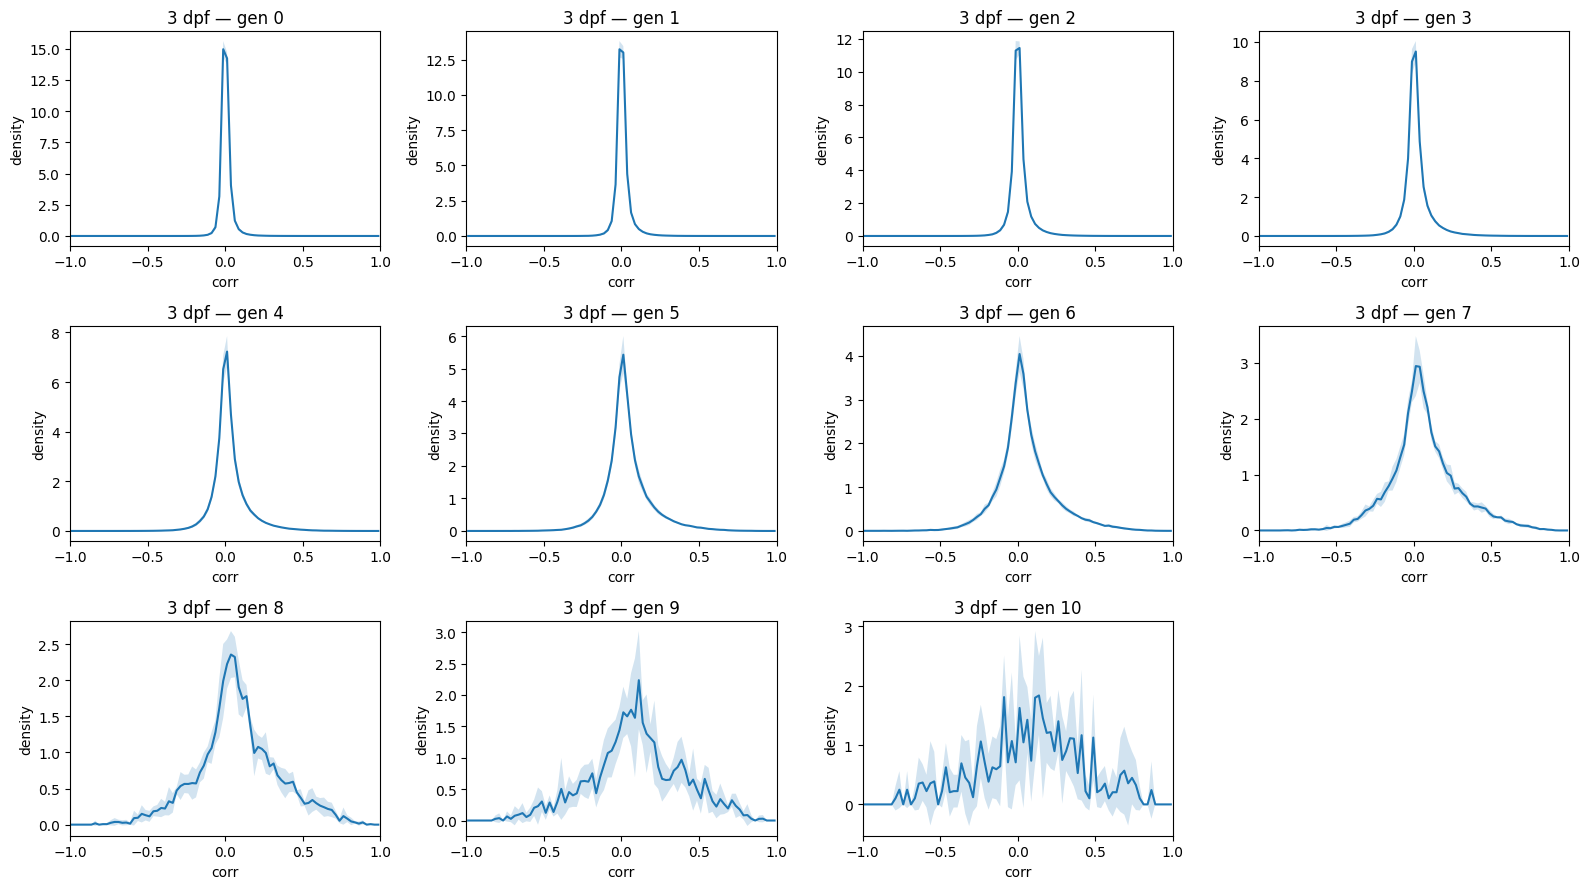

/tmp/ipykernel_193133/2070717941.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap("Spectral_r")


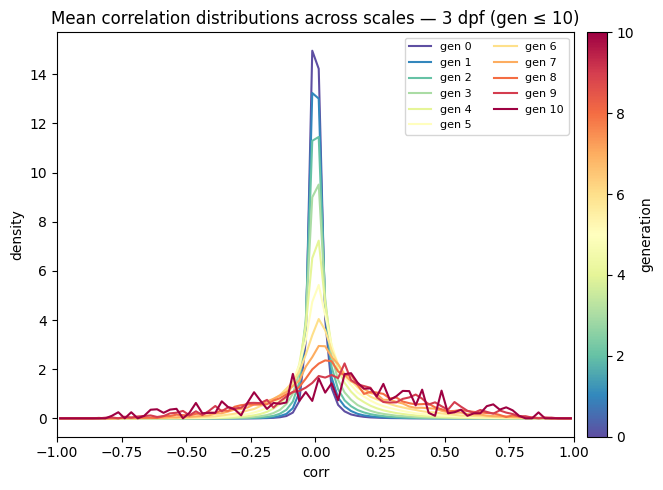

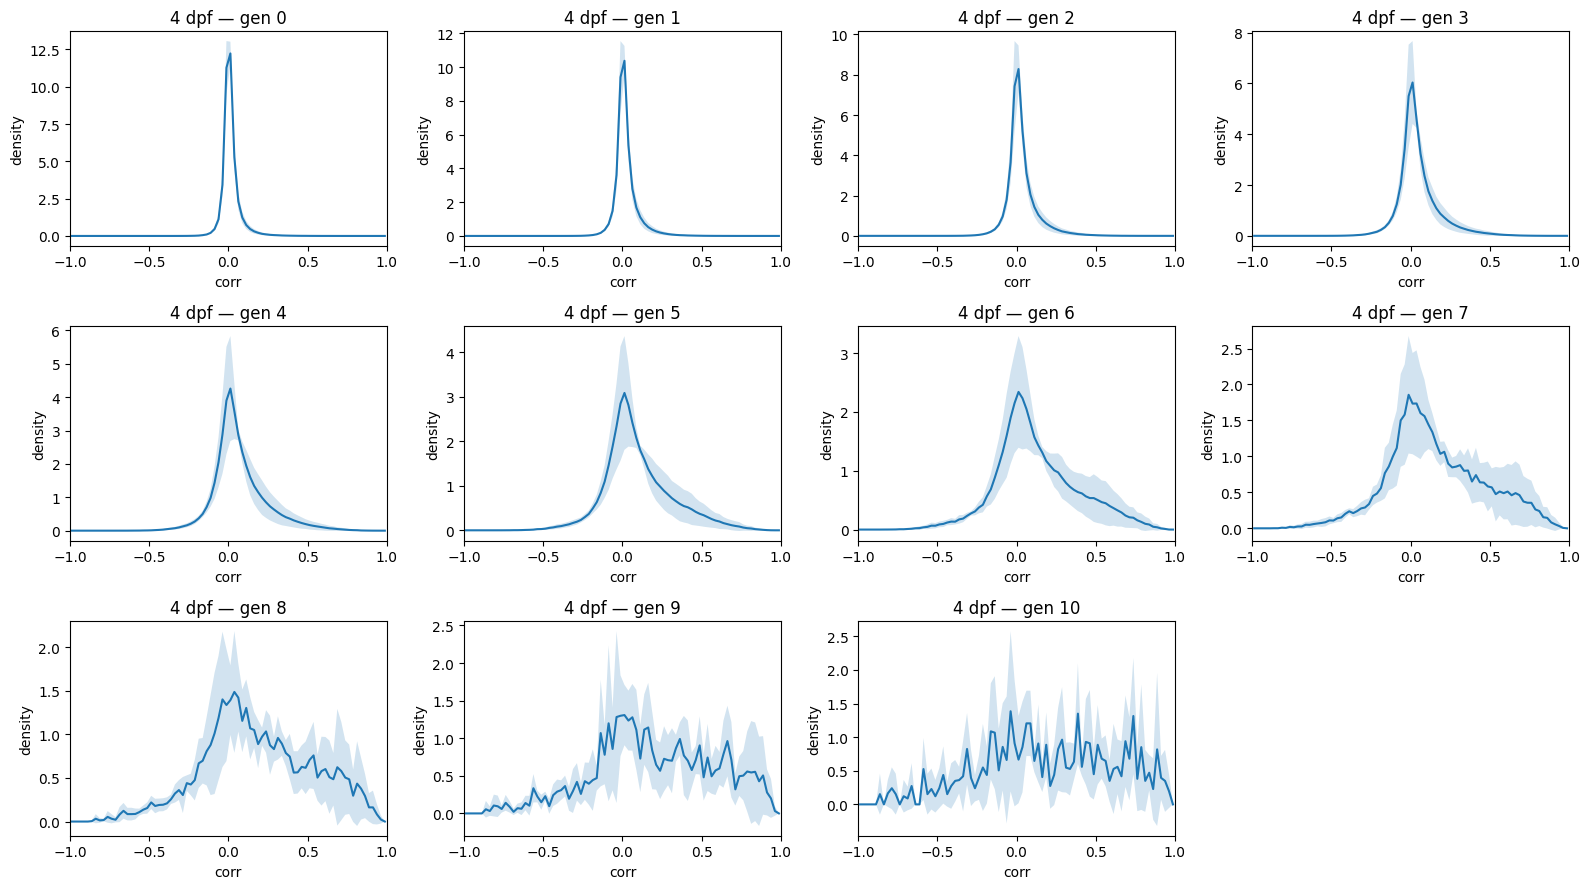

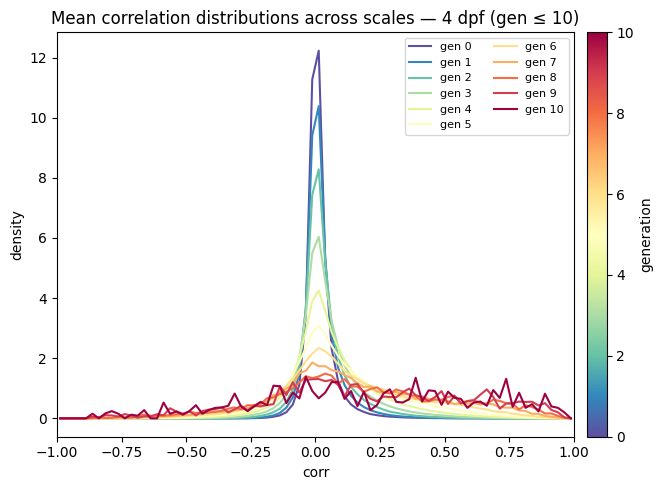

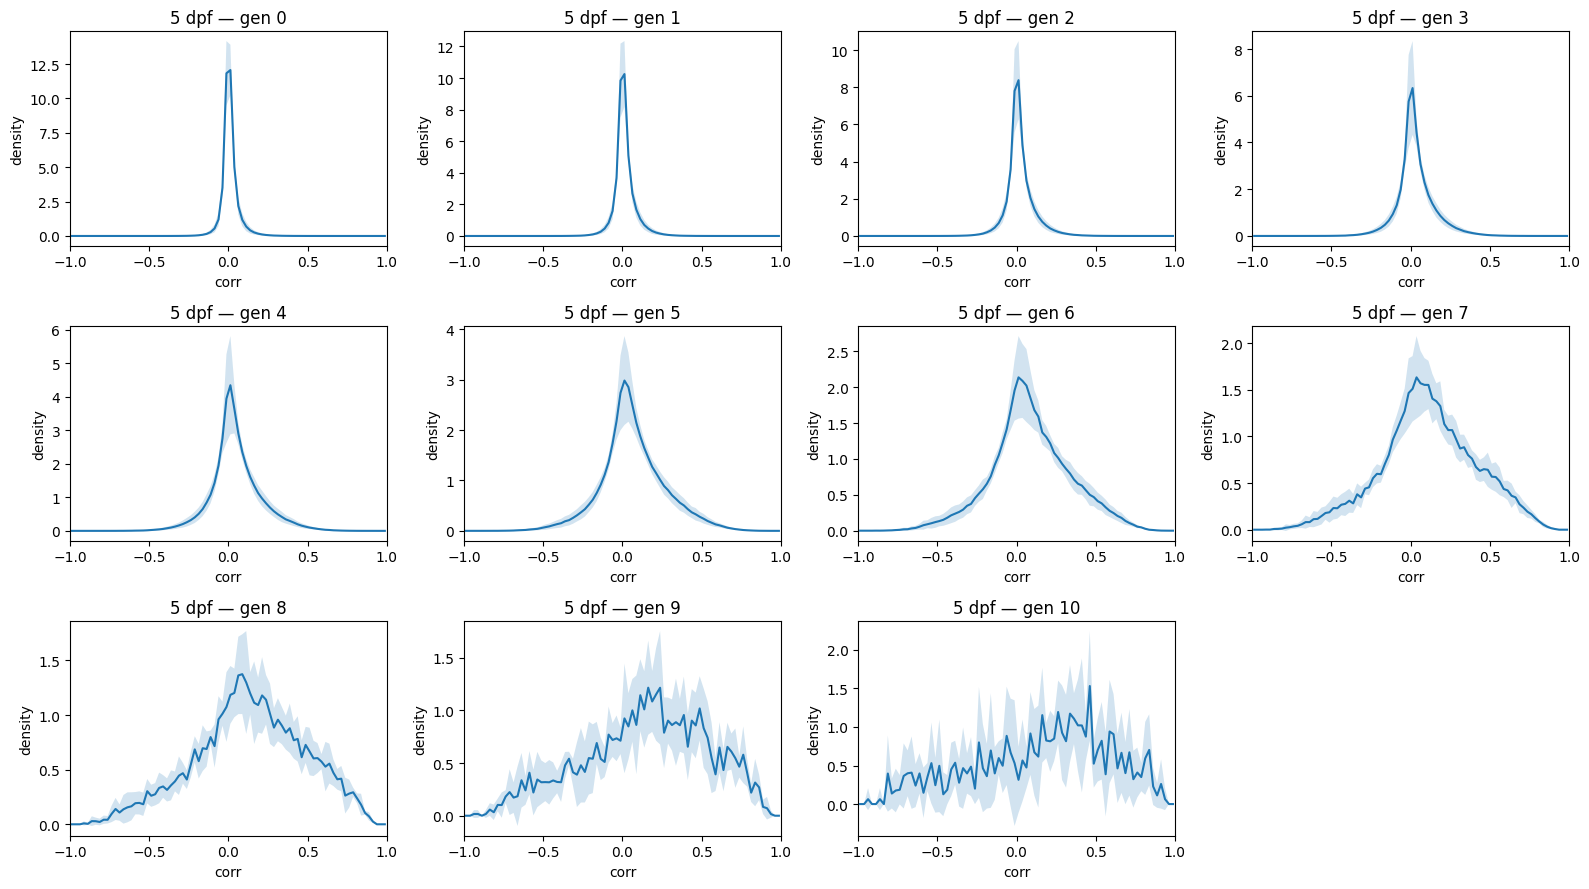

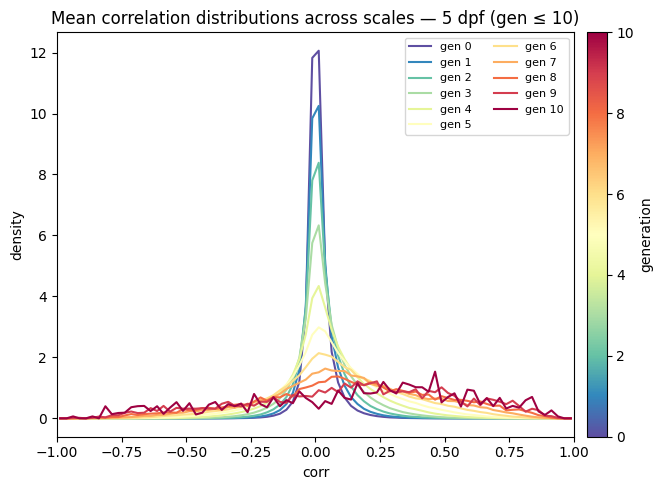

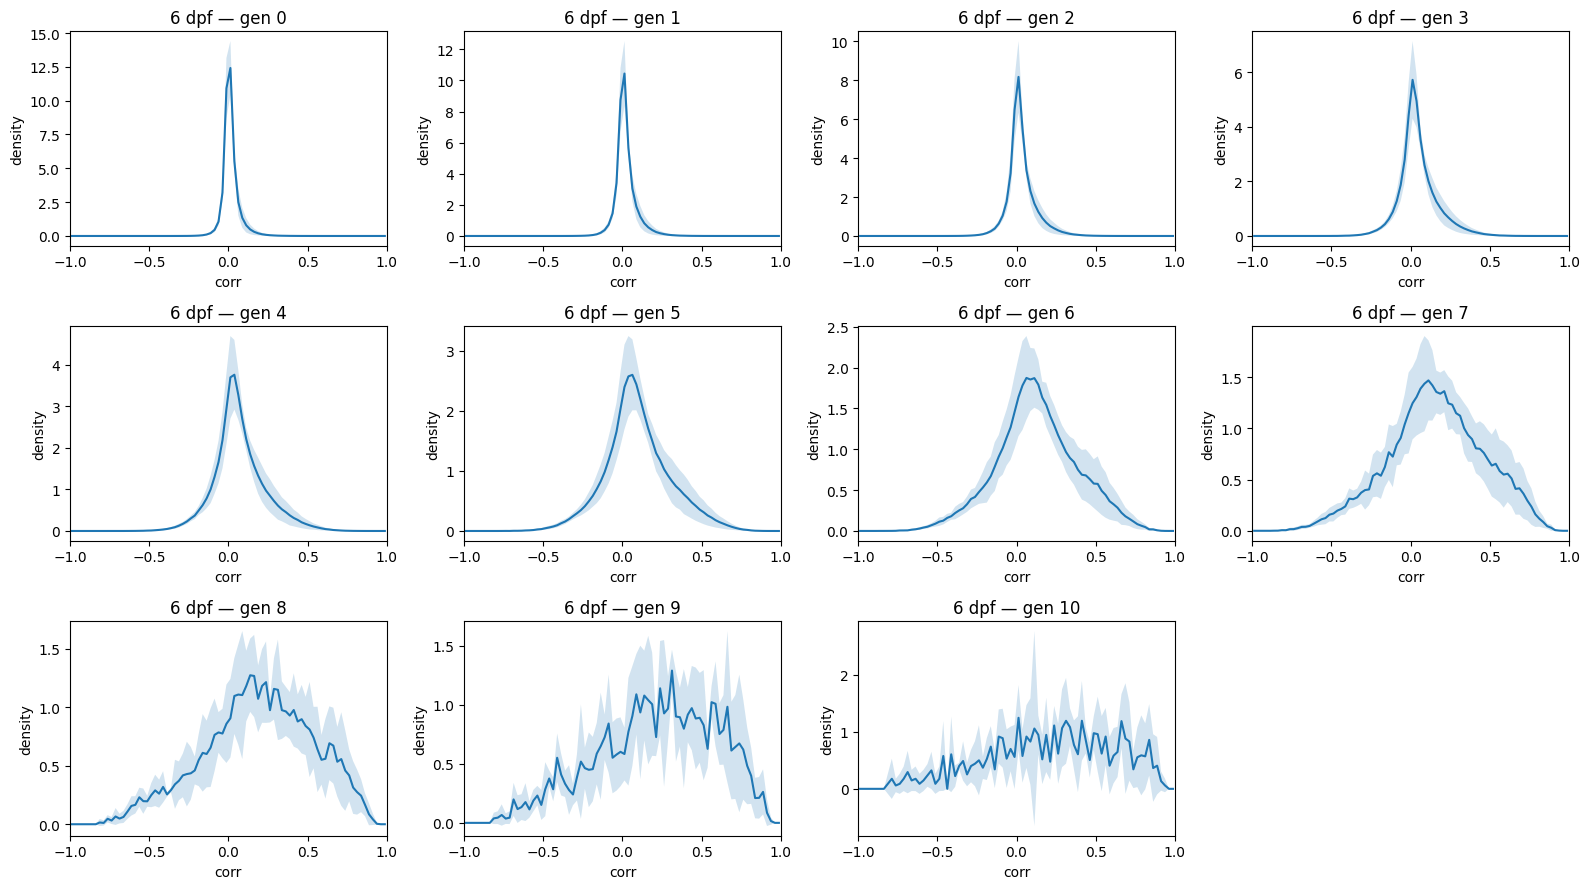

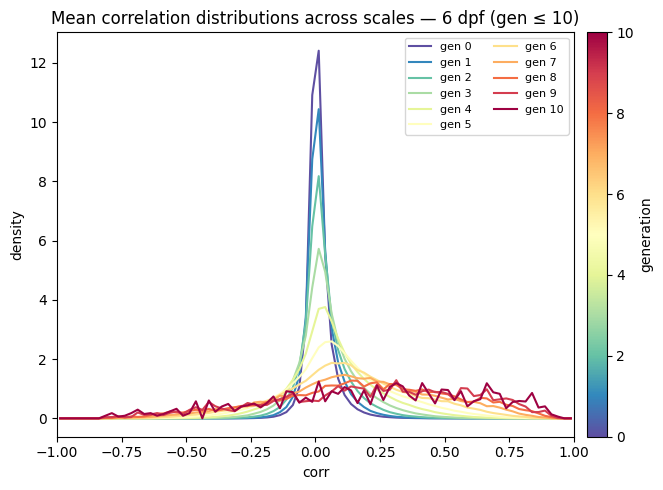

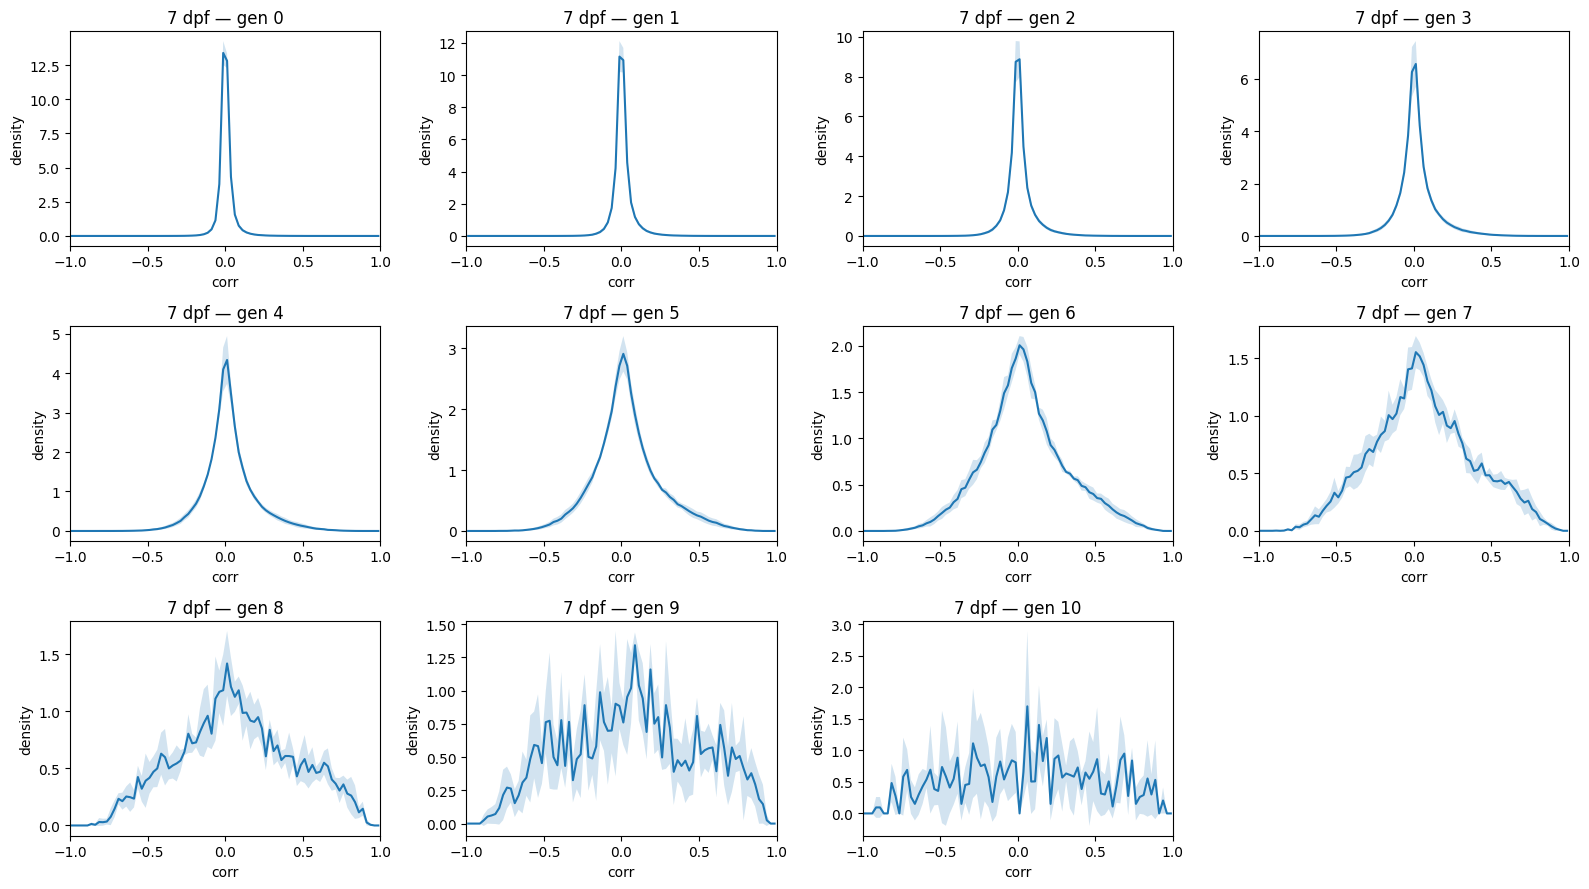

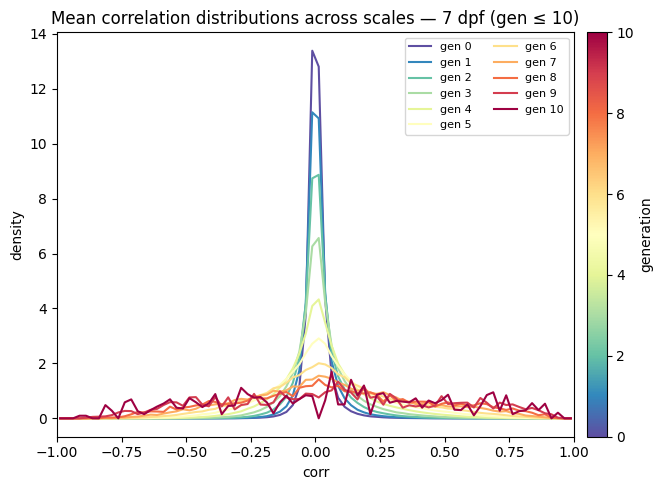

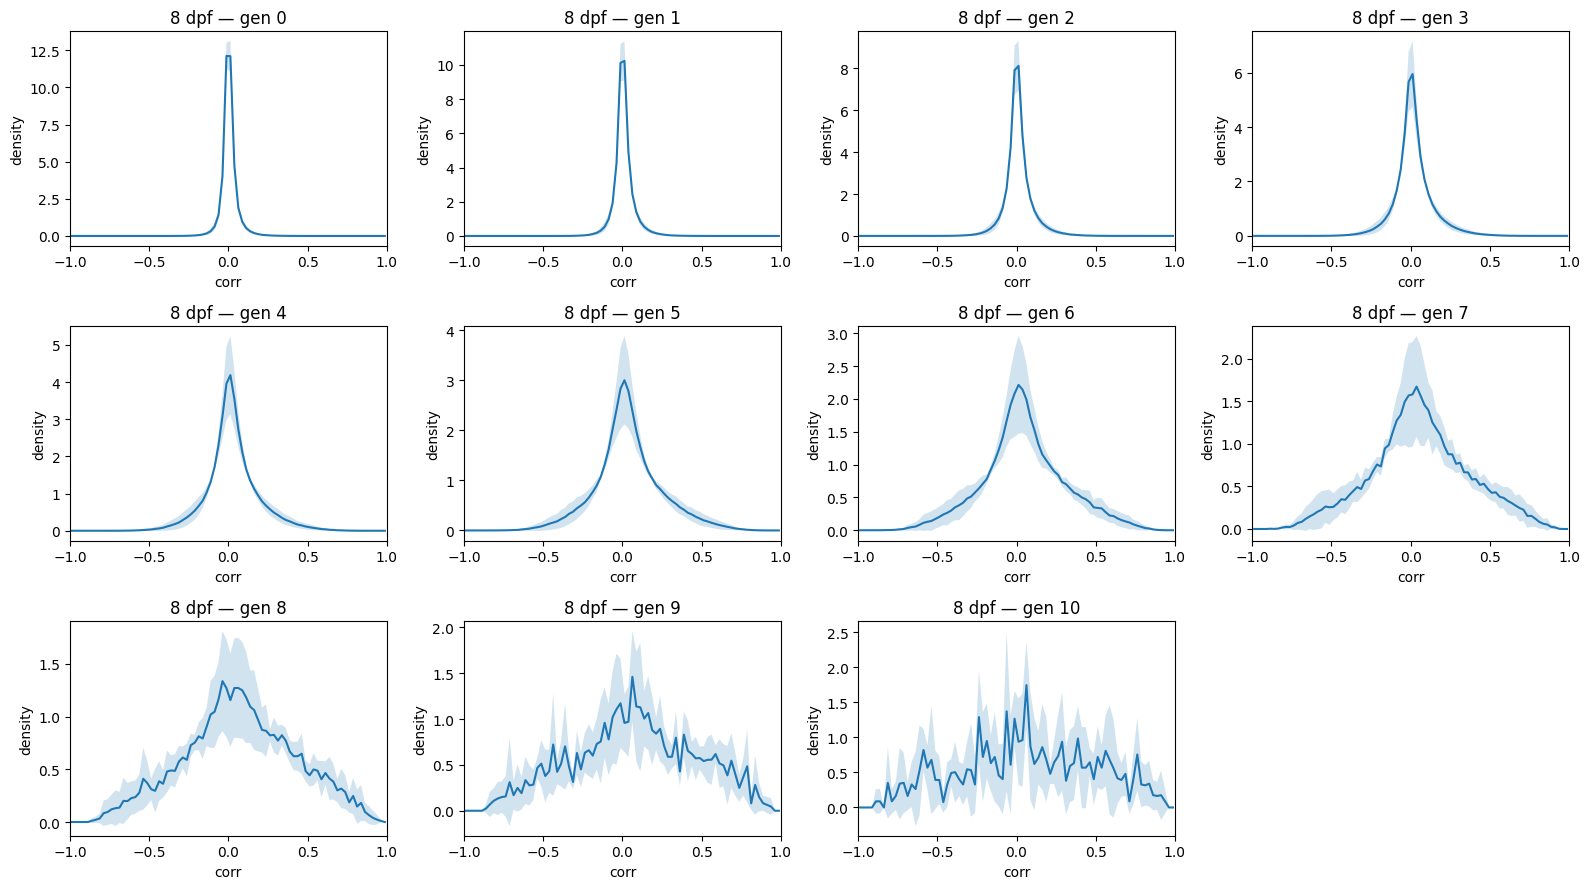

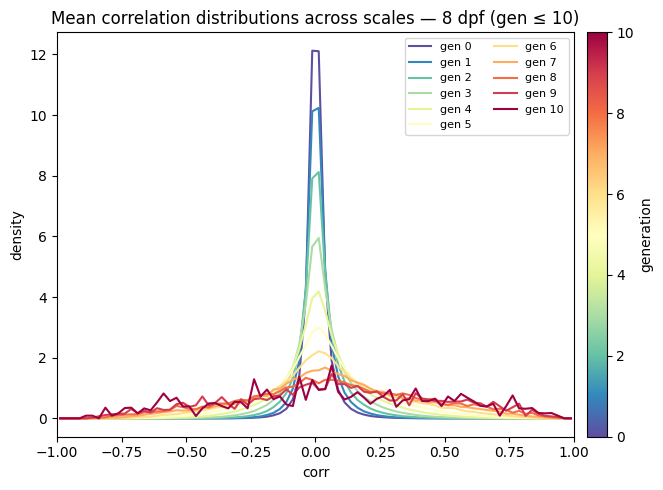


Saved plots to: /home/dburrows/DATA/BLNDEV-WILDTYPE/icg_npy/icg_corr_distributions


In [51]:
import os, re, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

ICG_DIR      = "/home/dburrows/DATA/BLNDEV-WILDTYPE/icg_npy/"
PATTERN = "*.npy"
OUT_DIR = os.path.join(ICG_DIR, "icg_corr_distributions")

# Pairwise corr estimation:
MAX_PAIRS = 200_000
BINS = np.linspace(-1, 1, 81)
EPS = 1e-6
SEED = 0

# Plotting
N_COLS = 4
PLOT_STD_BAND = True
SHOW_PLOTS = True

# Limit generations
MAX_GEN = 10  # <--- only include generations <= 10

# =========================
# Helpers
# =========================
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

def parse_age_dpf(path: str):
    base = os.path.basename(path)
    m = re.search(r"(\d+)\s*dpf", base, flags=re.IGNORECASE) or re.search(r"(\d+)dpf", base, flags=re.IGNORECASE)
    return int(m.group(1)) if m else None

def zscore_rows(X, eps=1e-6):
    X = np.asarray(X, dtype=np.float32)
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    sd = np.maximum(sd, eps)
    return (X - mu) / sd

def hist_density(x, bins):
    if x.size == 0:
        return np.full(len(bins) - 1, np.nan, dtype=np.float32)
    h, _ = np.histogram(x, bins=bins, density=True)
    return h.astype(np.float32)

def sample_pairwise_corrs(X, max_pairs=200_000, eps=1e-6, seed=0):
    X = np.asarray(X, dtype=np.float32)
    n, T = X.shape
    if n < 2:
        return np.array([], dtype=np.float32)

    Z = zscore_rows(X, eps=eps)
    total_pairs = n * (n - 1) // 2

    if (max_pairs is None) or (total_pairs <= max_pairs):
        C = (Z @ Z.T) / float(T)
        iu = np.triu_indices(n, k=1)
        return C[iu].astype(np.float32)

    rng = np.random.default_rng(seed)
    i = rng.integers(0, n, size=max_pairs, dtype=np.int32)
    j = rng.integers(0, n, size=max_pairs, dtype=np.int32)
    mask = i != j
    i, j = i[mask], j[mask]

    while i.size < max_pairs:
        need = max_pairs - i.size
        ii = rng.integers(0, n, size=need, dtype=np.int32)
        jj = rng.integers(0, n, size=need, dtype=np.int32)
        m = ii != jj
        i = np.concatenate([i, ii[m]])
        j = np.concatenate([j, jj[m]])

    i = i[:max_pairs]
    j = j[:max_pairs]
    lo = np.minimum(i, j)
    hi = np.maximum(i, j)

    corrs = (Z[lo] * Z[hi]).sum(axis=1) / float(T)
    return corrs.astype(np.float32)

def load_icg_npy(path: str):
    obj = np.load(path, allow_pickle=True)

    if isinstance(obj, np.ndarray) and obj.dtype == object:
        if obj.shape == ():
            obj = obj.item()
        elif obj.size == 1:
            obj = obj.reshape(()).item()

    if isinstance(obj, tuple):
        if len(obj) >= 3:
            generations = np.asarray(obj[0]).astype(int)
            mean_traces_by_gen = obj[2]
            if isinstance(mean_traces_by_gen, np.ndarray) and mean_traces_by_gen.dtype == object:
                mean_traces_by_gen = list(mean_traces_by_gen)
            elif not isinstance(mean_traces_by_gen, list):
                mean_traces_by_gen = list(mean_traces_by_gen)
            return generations, mean_traces_by_gen
        raise ValueError(f"{path}: tuple too short (len={len(obj)})")

    if isinstance(obj, dict):
        gen_key = next((k for k in ["generations", "gens", "gen"] if k in obj), None)
        mt_key  = next((k for k in ["mean_traces_by_gen", "mean_traces", "traces_by_gen", "X_by_gen"] if k in obj), None)
        if gen_key is None or mt_key is None:
            raise KeyError(f"{path}: dict keys present={sorted(obj.keys())}, couldn't find generations/mean_traces_by_gen")
        generations = np.asarray(obj[gen_key]).astype(int)
        mean_traces_by_gen = obj[mt_key]
        if isinstance(mean_traces_by_gen, np.ndarray) and mean_traces_by_gen.dtype == object:
            mean_traces_by_gen = list(mean_traces_by_gen)
        elif not isinstance(mean_traces_by_gen, list):
            mean_traces_by_gen = list(mean_traces_by_gen)
        return generations, mean_traces_by_gen

    raise TypeError(f"{path}: unsupported payload type {type(obj)}.")

# =========================
# Main
# =========================
ensure_dir(OUT_DIR)
paths = sorted(glob.glob(os.path.join(ICG_DIR, PATTERN)))
if not paths:
    raise FileNotFoundError(f"No .npy files matched: {os.path.join(ICG_DIR, PATTERN)}")

data_hist = {}
data_stats = {}

for p in paths:
    age = parse_age_dpf(p)
    if age is None:
        print(f"[WARN] Could not parse age from filename, skipping: {os.path.basename(p)}")
        continue

    generations, mean_traces_by_gen = load_icg_npy(p)

    # only keep generations <= MAX_GEN
    keep = [(g_idx, int(g)) for g_idx, g in enumerate(generations) if int(g) <= MAX_GEN]
    if not keep:
        continue

    for g_idx, g in keep:
        Xg = np.asarray(mean_traces_by_gen[g_idx], dtype=np.float32)
        corrs = sample_pairwise_corrs(Xg, max_pairs=MAX_PAIRS, eps=EPS, seed=SEED + 1000*g_idx)

        h = hist_density(corrs, BINS)
        data_hist.setdefault(age, {}).setdefault(g, []).append(h)

        if corrs.size > 0:
            data_stats.setdefault(age, {}).setdefault(g, []).append(
                (float(corrs.mean()), float(corrs.std(ddof=0)))
            )
        else:
            data_stats.setdefault(age, {}).setdefault(g, []).append((np.nan, np.nan))

ages = sorted(data_hist.keys())
if not ages:
    raise RuntimeError("No usable ages found (check filenames contain 'Xdpf') and that some gens <= MAX_GEN.")

bin_centers = 0.5 * (BINS[:-1] + BINS[1:])

print("\n=== Pairwise correlation summary (per age, per generation) ===")
for age in ages:
    gens = sorted(data_hist[age].keys())
    print(f"\nAge: {age} dpf")
    for g in gens:
        ms = np.array([m for (m, s) in data_stats[age][g]], dtype=float)
        ss = np.array([s for (m, s) in data_stats[age][g]], dtype=float)

        m_mean = np.nanmean(ms)
        m_sd_across_animals = np.nanstd(ms, ddof=0)
        s_mean = np.nanmean(ss)
        s_sd_across_animals = np.nanstd(ss, ddof=0)

        print(f"  gen {g:>2d}: mean(corr) = {m_mean:+.4f} (SD across animals {m_sd_across_animals:.4f})  "
              f"std(corr) = {s_mean:.4f} (SD across animals {s_sd_across_animals:.4f})")

for age in ages:
    gens = sorted(data_hist[age].keys())
    n_panels = len(gens)
    nrows = int(np.ceil(n_panels / N_COLS))

    # (1) grid
    fig = plt.figure(figsize=(4*N_COLS, 3*nrows))
    for idx, g in enumerate(gens):
        ax = fig.add_subplot(nrows, N_COLS, idx + 1)
        H = np.stack(data_hist[age][g], axis=0)

        m = np.nanmean(H, axis=0)
        s = np.nanstd(H, axis=0, ddof=0)

        ax.plot(bin_centers, m)
        if PLOT_STD_BAND and np.all(np.isfinite(s)):
            ax.fill_between(bin_centers, m - s, m + s, alpha=0.2)

        ax.set_title(f"{age} dpf — gen {g}")
        ax.set_xlabel("corr")
        ax.set_ylabel("density")
        ax.set_xlim(-1, 1)

    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"corr_dist_grid_{age}dpf_genLE{MAX_GEN}.png"), dpi=200)
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

    # (2) overlay with Spectral_r, sequential by gen value
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(1, 1, 1)

    cmap = mpl.cm.get_cmap("Spectral_r")
    norm = mpl.colors.Normalize(vmin=min(gens), vmax=max(gens) if max(gens) > min(gens) else min(gens) + 1e-9)

    for g in gens:
        H = np.stack(data_hist[age][g], axis=0)
        m = np.nanmean(H, axis=0)
        ax.plot(bin_centers, m, color=cmap(norm(g)), label=f"gen {g}")

    ax.set_title(f"Mean correlation distributions across scales — {age} dpf (gen ≤ {MAX_GEN})")
    ax.set_xlabel("corr")
    ax.set_ylabel("density")
    ax.set_xlim(-1, 1)

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label("generation")

    ax.legend(fontsize=8, ncol=2)

    fig.tight_layout()
    fig.savefig(os.path.join(OUT_DIR, f"corr_dist_overlay_{age}dpf_genLE{MAX_GEN}.png"), dpi=200)
    if SHOW_PLOTS:
        plt.show()
    else:
        plt.close(fig)

print(f"\nSaved plots to: {OUT_DIR}")


In [114]:
import numpy as np

def corr(X, max_pairs=200_000, eps=1e-6, seed=0):
    X = np.asarray(X, dtype=np.float32)
    n, T = X.shape
    if n < 2:
        return (np.array([], dtype=np.float32),
                np.array([], dtype=np.int32),
                np.array([], dtype=np.int32))

    Z = zscore_rows(X, eps=eps)
    total_pairs = n * (n - 1) // 2

    # --- exact (all pairs) ---
    if (max_pairs is None) or (total_pairs <= max_pairs):
        C = (Z @ Z.T) / float(T)
        i, j = np.triu_indices(n, k=1)
        corrs = C[i, j].astype(np.float32)
        return corrs, i.astype(np.int32), j.astype(np.int32)

    # --- sampled pairs (with replacement) ---
    rng = np.random.default_rng(seed)

    i = rng.integers(0, n, size=max_pairs, dtype=np.int32)
    j = rng.integers(0, n, size=max_pairs, dtype=np.int32)
    mask = i != j
    i, j = i[mask], j[mask]

    while i.size < max_pairs:
        need = max_pairs - i.size
        ii = rng.integers(0, n, size=need, dtype=np.int32)
        jj = rng.integers(0, n, size=need, dtype=np.int32)
        m = ii != jj
        i = np.concatenate([i, ii[m]])
        j = np.concatenate([j, jj[m]])

    i = i[:max_pairs]
    j = j[:max_pairs]
    lo = np.minimum(i, j)
    hi = np.maximum(i, j)

    corrs = (Z[lo] * Z[hi]).sum(axis=1) / float(T)
    return corrs.astype(np.float32), lo.astype(np.int32), hi.astype(np.int32)

In [91]:
young = glob.glob(f'{fdata}/*3dp*regdeltaff.npy')
old = glob.glob(f'{fdata}/*8dp*regdeltaff.npy')
old

['/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-06_2photon_sess-01-8dpf_BLNGR_run-01_regdeltaff.npy',
 '/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-05_2photon_sess-01-8dpf_BLNGR_run-01_regdeltaff.npy',
 '/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-08_2photon_sess-01-8dpf_BLNGR_run-01_regdeltaff.npy',
 '/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-01_2photon_sess-01-8dpf_BLNGR_run-01_regdeltaff.npy',
 '/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-04_2photon_sess-01-8dpf_BLNGR_run-01_regdeltaff.npy']

In [117]:
corr(np.load(young[0]))

(array([-0.00124531, -0.00261594, -0.01155443, ...,  0.1151327 ,
        -0.10716999, -0.00158273], shape=(200000,), dtype=float32),
 array([2930, 7425, 6252, ..., 3464,  587, 4211],
       shape=(200000,), dtype=int32),
 array([10405,  7791,  7916, ...,  4356,  5708, 12215],
       shape=(200000,), dtype=int32))

In [126]:
#what is driving this kurtosis shift
#=======================================

# confirm what is changing in the tails
def kurtosis(corr):
    x = np.asarray(corr[0], dtype=np.float64)
    x = x[np.isfinite(x)]
    if x.size < 4:
        return np.nan
    num = np.mean((x - np.mean(x))**4)
    den = np.var(x)**2
    return(num/den)

k_young = np.array([kurtosis(corr(np.load(i))) for i in young])
k_old = np.array([kurtosis(corr(np.load(i))) for i in old])

<Axes: >

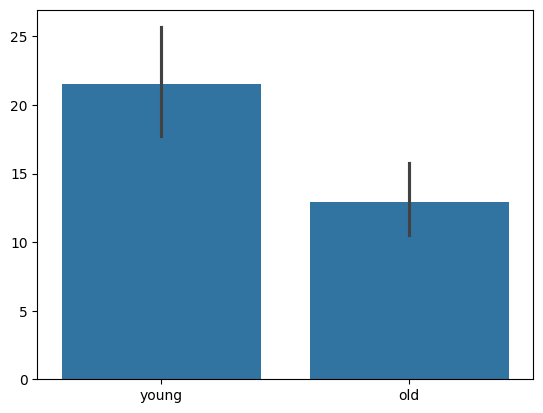

In [137]:
import seaborn as sns
sns.barplot(y=np.append(k_young,k_old), x=np.append(['young']*len(young), ['old']*len(old)))

In [201]:
#find location in distribution of kurtosis
def kurtosis_tail(x, ks=(0,1,2,3,4,5,6,7,8), eps=1e-12):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    if x.size < 4:
        return {k: np.nan for k in ks}

    s = x.std()
    if s < eps:
        return {k: np.nan for k in ks}

    z = (x - x.mean()) / s
    w = z**4                      # per-sample "kurtosis weight"
    tot = w.mean()                # = kurtosis

    out = {}
    for k in ks:
        out[k] = w[np.abs(z) >= k].sum()   # fraction of kurtosis from |z|>=k
    return out

#p, fraction, sensitivity


In [202]:
young_tail = np.ravel([list(kurtosis_tail(corr(np.load(i))[0]).values()) for i in young])
old_tail = np.ravel([list(kurtosis_tail(corr(np.load(i))[0]).values()) for i in old])
z = np.tile(np.arange(0,9),len(young) + len(old))
mode = np.append(np.repeat('young', len(young_tail)), np.repeat('old', len(old_tail)))
df = pd.DataFrame({'age':mode, 'k':np.append(young_tail, old_tail), 'z':z})

<Axes: xlabel='z', ylabel='k'>

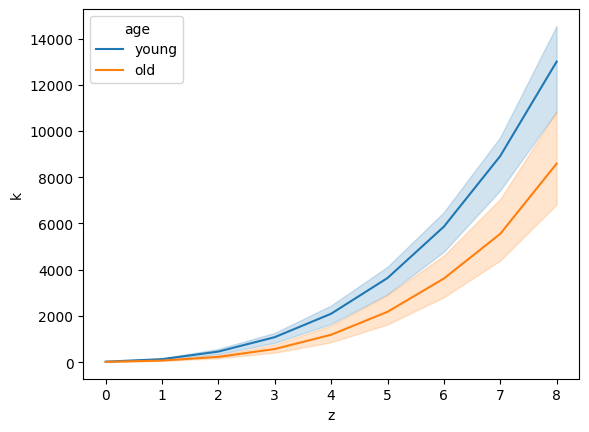

In [200]:
sns.lineplot(data = df, y = df['k'], x = 'z', hue = 'age')

<Axes: xlabel='z', ylabel='k'>

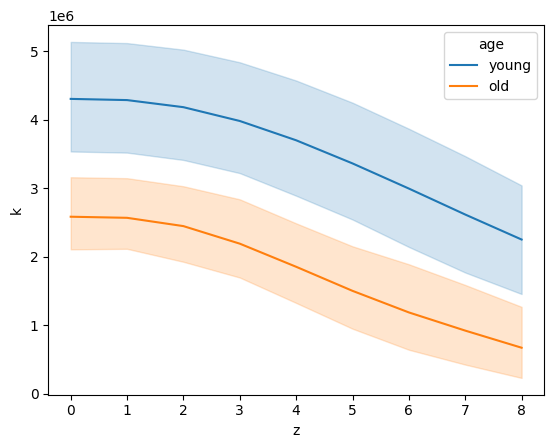

In [203]:
sns.lineplot(data = df, y = df['k'], x = 'z', hue = 'age')

In [207]:
x  = corr(np.load(dff_l[0]))[0]

In [262]:
def z_w(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    s = x.std()
    z = (x - x.mean()) / s
    w = z**4                      # per-sample "kurtosis weight"
    return(z,w)

In [246]:
i=0
yz, yw = z_w(corr(np.load(young[i]))[0])
oz, ow = z_w(corr(np.load(old[i]))[0])

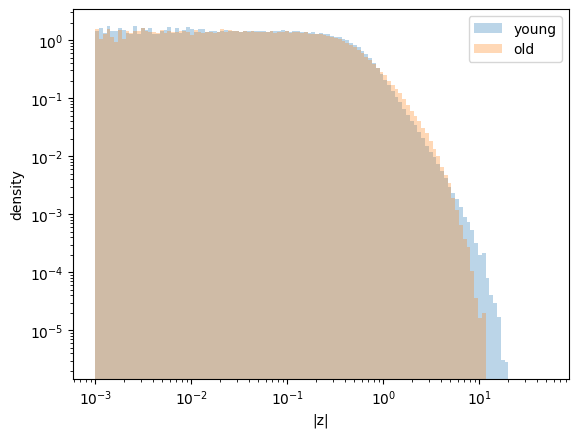

max |z| young/old: 18.764950227796636 11.47911276767234


In [244]:
bins = np.geomspace(1e-3, 50, 120)  # extend beyond 10

plt.hist(np.abs(yz), bins=bins, density=True, alpha=0.3, label="young")
plt.hist(np.abs(oz), bins=bins, density=True, alpha=0.3, label="old")
plt.xscale("log")
plt.yscale("log")  # THIS is usually what reveals tail differences
plt.xlabel("|z|")
plt.ylabel("density")
plt.legend()
plt.show()

print("max |z| young/old:", np.abs(yz).max(), np.abs(oz).max())

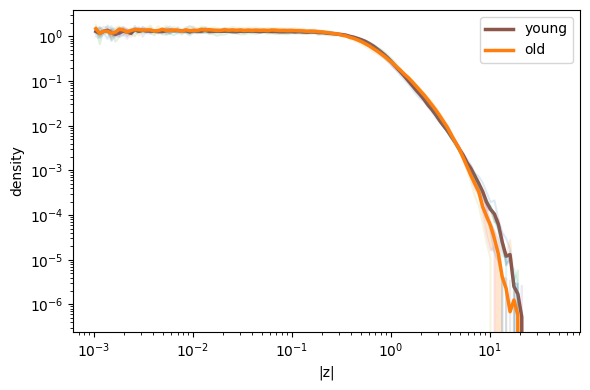

max |z| young per fish: [18.76495023 17.39941901 19.49174693 14.16761105 20.90815908]
max |z| old   per fish: [11.47911277 15.97800109 10.37993467 19.45925054 13.59189234]


In [251]:
import numpy as np
import matplotlib.pyplot as plt

def absz_density_per_fish(paths, bins):
    dens = []
    max_absz = []
    for p in paths:
        x = corr(np.load(p))[0]
        z, _ = z_w(x)
        az = np.abs(z)
        h, _ = np.histogram(az[np.isfinite(az)], bins=bins, density=True)
        dens.append(h.astype(np.float64))
        max_absz.append(np.nanmax(az))
    return np.vstack(dens), np.array(max_absz)

bins = np.geomspace(1e-3, 50, 120)
bin_cent = np.sqrt(bins[:-1] * bins[1:])  # geometric midpoints for log x

yd, ymax = absz_density_per_fish(young, bins)
od, omax = absz_density_per_fish(old, bins)

def plot_group(dens, label, alpha_lines=0.15):
    for h in dens:
        plt.plot(bin_cent, h, alpha=alpha_lines)
    m = np.nanmean(dens, axis=0)
    lo = np.nanpercentile(dens, 25, axis=0)
    hi = np.nanpercentile(dens, 75, axis=0)
    plt.plot(bin_cent, m, linewidth=2.5, label=label)
    plt.fill_between(bin_cent, lo, hi, alpha=0.2)

plt.figure(figsize=(6,4))
plot_group(yd, "young")
plot_group(od, "old")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("|z|"); plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()

print("max |z| young per fish:", ymax)
print("max |z| old   per fish:", omax)


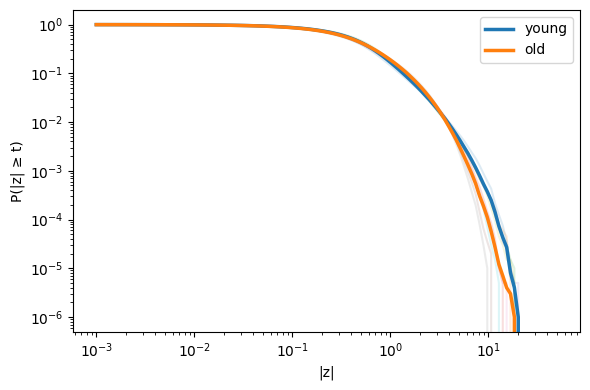

In [252]:
def ccdf_from_absz(az, grid):
    az = az[np.isfinite(az)]
    az.sort()
    # P(|z| >= t) = 1 - CDF(t)
    return np.array([(az.size - np.searchsorted(az, t, side="left")) / az.size for t in grid])

grid = np.geomspace(1e-3, 50, 120)

def ccdf_per_fish(paths, grid):
    Ys = []
    for p in paths:
        x = corr(np.load(p))[0]
        z, w = z_w(x)
        Ys.append(ccdf_from_absz(np.abs(z), grid))
    return np.vstack(Ys)

Yy = ccdf_per_fish(young, grid)
Yo = ccdf_per_fish(old, grid)

plt.figure(figsize=(6,4))
for y in Yy: plt.plot(grid, y, alpha=0.15)
for y in Yo: plt.plot(grid, y, alpha=0.15)

plt.plot(grid, Yy.mean(axis=0), linewidth=2.5, label="young")
plt.plot(grid, Yo.mean(axis=0), linewidth=2.5, label="old")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("|z|"); plt.ylabel("P(|z| ≥ t)")
plt.legend()
plt.tight_layout()
plt.show()


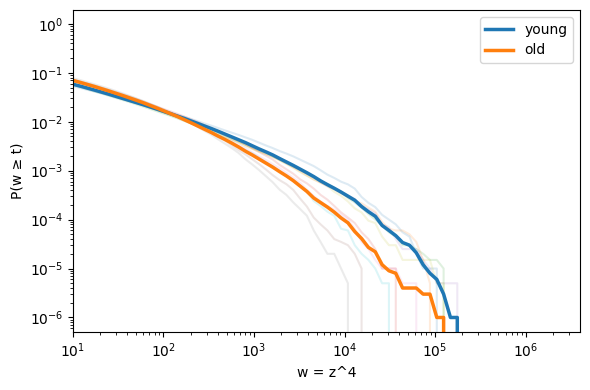

In [255]:
import numpy as np
import matplotlib.pyplot as plt

def ccdf_from_nonneg(x, grid):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    x.sort()
    n = x.size
    if n == 0:
        return np.full_like(grid, np.nan, dtype=float)
    return np.array([(n - np.searchsorted(x, t, side="left")) / n for t in grid])

def ccdf_per_fish_w(paths, grid):
    Ys = []
    for p in paths:
        x = corr(np.load(p))[0]
        z, w = z_w(x)          # w = z^4
        Ys.append(ccdf_from_nonneg(w, grid))
    return np.vstack(Ys)

wgrid = np.geomspace(1e-6, 1e6, 160)  # adjust range if needed

Wy = ccdf_per_fish_w(young, wgrid)
Wo = ccdf_per_fish_w(old, wgrid)

plt.figure(figsize=(6,4))
for y in Wy: plt.plot(wgrid, y, alpha=0.15)
for y in Wo: plt.plot(wgrid, y, alpha=0.15)

plt.plot(wgrid, Wy.mean(axis=0), linewidth=2.5, label="young")
plt.plot(wgrid, Wo.mean(axis=0), linewidth=2.5, label="old")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("w = z^4"); plt.ylabel("P(w ≥ t)")
plt.legend()
plt.xlim(10)
plt.tight_layout()
plt.show()

In [ ]:
#save template cells


In [323]:
import numpy as np
from tqdm import tqdm

# coord_l: list of filepaths to coord arrays (N_i, 7) object arrays

xyz_all = []
for p in tqdm(coord_l):
    coord = np.load(p, allow_pickle=True)
    xyz_all.append(coord[:, :3].astype(np.float32))  # (N_i, 3)

xyz_all = np.vstack(xyz_all)  # (sum_i N_i, 3)

print("stacked xyz shape:", xyz_all.shape)

np.save("coords_xyz_stacked.npy", xyz_all)


100%|█████████| 30/30 [00:00<00:00, 140.05it/s]

stacked xyz shape: (405393, 3)


In [325]:
allcoord = np.load("coords_xyz_stacked.npy", allow_pickle=True)
allcoord.shape

(405393, 3)

In [ ]:
#identify kurtotic cell pairs at 3dpf -> types of correlations//dynamics, location in brain, distance
#what happens to centre of mass with age -> 

In [298]:
adfn.save_name(young[0]) + '_labcoord_new.npy'

'/home/dburrows/DATA/BLNDEV-WILDTYPE/BLNDEV-WILDTYPE-05_2photon_sess-01-3dpf_BLNGR_run-01_labcoord_new.npy'

In [303]:
coord = np.load(adfn.save_name(young[0]) + '_labcoord_newreg.npy', allow_pickle=True)
curr = corr(np.load(young[0]))

In [306]:
coord

array([['385.5', '590.8333333333334', '134.38888888888889', ...,
        'Hindbrain', 'Hindbrain (rhombomeres)', 'Reticular_formation'],
       ['215.1081081081081', '316.13513513513516', '132.72972972972974',
        ..., 'Midbrain', 'Tectal band/Griseum', 'Tectum'],
       ['271.85', '604.6', '136.25', ..., 'Hindbrain',
        'Hindbrain (rhombomeres)', 'Reticular_formation'],
       ...,
       ['92.26666666666667', '383.3333333333333', '270.6', ..., 'nan',
        'Other/Drop', 'Nan'],
       ['111.3157894736842', '508.36842105263156', '273.3157894736842',
        ..., 'nan', 'Other/Drop', 'Nan'],
       ['113.66666666666667', '419.8333333333333', '270.94444444444446',
        ..., 'Hindbrain', 'Other/Drop', 'Nan']],
      shape=(12233, 7), dtype=object)

In [292]:
# identify frequently occuring corr neurons

z,w = z_w(curr[0])
z = np.abs(z)
boole = (z > 3)
inp = curr[1][boole]
outp = curr[2][boole]

comb = np.append(inp,outp)
comb

array([2144, 7826, 5373, ..., 4440, 8973, 3097],
      shape=(7588,), dtype=int32)

(array([1926.,  395.,  271.,  171.,  114.,  111.,   18.,   10.,    7.,
           5.]),
 array([ 1. ,  2.2,  3.4,  4.6,  5.8,  7. ,  8.2,  9.4, 10.6, 11.8, 13. ]),
 <BarContainer object of 10 artists>)

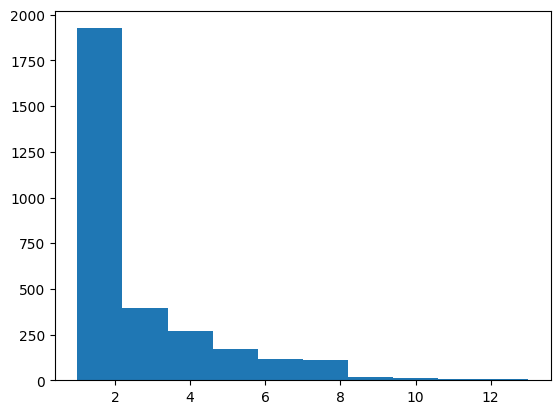

In [304]:
plt.hist(np.unique(comb, return_counts=True)[1])

In [328]:
allcoord = np.load("coords_xyz_stacked.npy", allow_pickle=True)
allcoord

array([[326.72726, 439.4091 , 123.27273],
       [208.95454, 562.0455 , 125.36364],
       [440.     , 530.7857 , 125.28571],
       ...,
       [291.63635, 235.     , 217.77272],
       [534.26666, 297.8    , 216.6    ],
       [264.     , 442.91666, 220.5    ]],
      shape=(405393, 3), dtype=float32)

Cells with >= 3 appearances: 1102


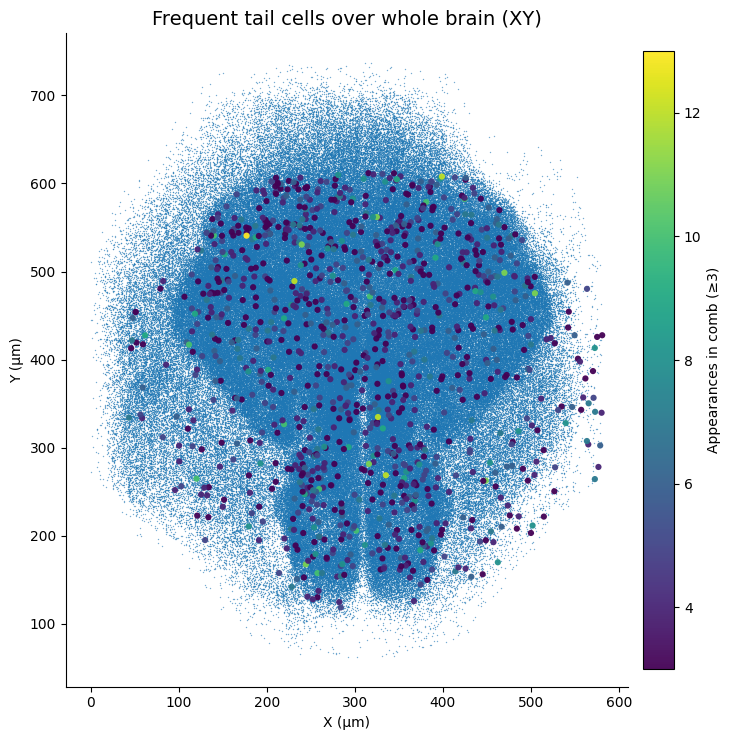

In [327]:
import numpy as np
import matplotlib.pyplot as plt

# coord: (N,7) object array; coord[:,0:3] are XYZ strings
# comb : 1D array of cell indices (ints)

xyz = coord[:, :3].astype(np.float32)
X, Y = xyz[:, 0], xyz[:, 1]

comb = np.asarray(comb, dtype=np.int32)
counts = np.bincount(comb, minlength=xyz.shape[0])

min_appear = 3  # >2 appearances
idx = np.flatnonzero(counts >= min_appear)
freq = counts[idx].astype(np.int32)

print(f"Cells with >= {min_appear} appearances: {idx.size}")

fig, ax = plt.subplots(figsize=(8.5, 7.5))

# whole brain background
ax.scatter(allcoord[:,0], allcoord[:,1], s=1, alpha=0.6, linewidths=0)

# frequent cells overlay (colored by frequency)
sc = ax.scatter(X[idx], Y[idx], c=freq, s=20, alpha=0.95, linewidths=0)

cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label(f"Appearances in comb (≥{min_appear})")

ax.set_title("Frequent tail cells over whole brain (XY)", fontsize=14)
ax.set_xlabel("X (µm)")
ax.set_ylabel("Y (µm)")
ax.set_aspect("equal", adjustable="box")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# 

In [ ]:
# network -> at increasing scales -> location of kurtotic nodes

In [26]:
#correlation length

fdata = "/home/dburrows/DATA/BLNDEV-WILDTYPE"
dff_l  = np.sort(glob.glob(f"{fdata}/*regdeltaff*"))
coord_l  = np.sort(glob.glob(f"{fdata}/*labcoord*"))

curr = np.load(coord_l[0], allow_pickle=True)
xyz = curr[:,:3].astype(float) *[.8, .8, 15] #define distance of each pixel in x,y,z
dff = np.load(dff_l[0], allow_pickle=True)

In [7]:
xyz.shape, dff.shape

((15105, 3), (15105, 4914))

In [46]:
#within plane only
import os, re, glob
import numpy as np
import pandas as pd
from tqdm import tqdm

try:
    from scipy.optimize import curve_fit
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# -------------------------
# filename parsers
# -------------------------
def parse_fish_id(path: str) -> str:
    base = os.path.basename(path)
    m = re.search(r"(BLNDEV-WILDTYPE-\d+)", base)
    return m.group(1) if m else base.split("_")[0]

def parse_age_dpf(path: str) -> float:
    base = os.path.basename(path)
    m = re.search(r"(\d+)\s*dpf", base, flags=re.IGNORECASE) or re.search(r"(\d+)dpf", base, flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

# -------------------------
# helpers
# -------------------------
def zscore_rows(X, eps=1e-6):
    X = np.asarray(X, dtype=np.float32)
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    return (X - mu) / (sd + eps)

def bin_mean_abs_corr(d, r, nbins=60, dmax=None):
    d = np.asarray(d, dtype=np.float32)
    r = np.asarray(r, dtype=np.float32)
    if dmax is None:
        dmax = np.nanpercentile(d, 99.5)
    edges = np.linspace(0.0, float(dmax), nbins + 1, dtype=np.float32)
    centers = 0.5 * (edges[:-1] + edges[1:])
    which = np.clip(np.searchsorted(edges, d, side="right") - 1, 0, nbins - 1)

    y = np.zeros(nbins, dtype=np.float32)
    n = np.zeros(nbins, dtype=np.int64)
    absr = np.abs(r)

    np.add.at(y, which, absr)
    np.add.at(n, which, 1)
    y = np.where(n > 0, y / np.maximum(n, 1), np.nan)
    return centers, y, n, edges

def fit_xi_exponential(d_centers, y, n=None, fit_min_um=0.0, fit_max_um=None):
    d_centers = np.asarray(d_centers, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    ok = np.isfinite(d_centers) & np.isfinite(y) & (y > 0)
    if fit_max_um is not None:
        ok &= (d_centers <= float(fit_max_um))
    ok &= (d_centers >= float(fit_min_um))

    dfit = d_centers[ok]
    yfit = y[ok]
    if dfit.size < 6:
        return np.nan, (np.nan, np.nan), False

    if n is not None:
        w = np.sqrt(np.asarray(n, dtype=np.float64)[ok])
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    else:
        w = None

    def model(d, a, xi, c):
        return a * np.exp(-d / xi) + c

    c0 = np.nanmin(yfit[-max(3, yfit.size//5):])
    a0 = max(np.nanmax(yfit) - c0, 1e-6)
    xi0 = max(np.nanmedian(dfit), 1.0)

    if _HAS_SCIPY:
        try:
            popt, _ = curve_fit(
                model, dfit, yfit,
                p0=(a0, xi0, c0),
                bounds=([0.0, 1e-3, 0.0], [np.inf, np.inf, np.inf]),
                sigma=(1.0 / w) if w is not None else None,
                absolute_sigma=False,
                maxfev=20_000
            )
            a, xi, c = popt
            return float(xi), (float(a), float(c)), True
        except Exception:
            pass

    # fallback: log-linear after subtracting baseline estimate
    y2 = yfit - c0
    ok2 = y2 > 0
    if ok2.sum() < 6:
        return np.nan, (np.nan, np.nan), False
    d2 = dfit[ok2]
    ly = np.log(y2[ok2])
    A = np.c_[np.ones_like(d2), -d2]
    coef, *_ = np.linalg.lstsq(A, ly, rcond=None)
    slope = coef[1]
    xi = 1.0 / max(slope, 1e-12)
    return float(xi), (np.nan, float(c0)), True

# -------------------------
# NEW: sample only within-plane pairs (same z index)
# -------------------------
def sample_pair_corr_dist_inplane(Z, x_um, y_um, z_idx, n_pairs=1_000_000, seed=0,
                                  chunk_pairs=200_000, oversample_factor=3):
    """
    Returns (d_xy, r) for pairs with z_idx[i] == z_idx[j].
    Distance is XY only in microns.
    """
    rng = np.random.default_rng(seed)
    N, T = Z.shape

    d = np.empty(int(n_pairs), dtype=np.float32)
    r = np.empty(int(n_pairs), dtype=np.float32)

    filled = 0
    while filled < n_pairs:
        m = int(min((n_pairs - filled) * oversample_factor, 2_000_000))
        i = rng.integers(0, N, size=m, dtype=np.int32)
        j = rng.integers(0, N, size=m, dtype=np.int32)

        ok = (i != j) & (z_idx[i] == z_idx[j])
        ii = i[ok]
        jj = j[ok]
        if ii.size == 0:
            continue

        take = min(ii.size, n_pairs - filled)
        ii = ii[:take]
        jj = jj[:take]

        # distances (XY only)
        dx = x_um[ii] - x_um[jj]
        dy = y_um[ii] - y_um[jj]
        d[filled:filled+take] = np.sqrt(dx*dx + dy*dy).astype(np.float32)

        # correlations
        # (z-scored => corr = mean product)
        r[filled:filled+take] = (np.einsum("nt,nt->n", Z[ii], Z[jj], optimize=True) / (T - 1)).astype(np.float32)

        filled += take

    return d, r

# -------------------------
# high-level: compute xi within-plane for one file
# -------------------------
def correlation_length_inplane_from_files(dff_path, coord_path, *,
                                          xy_um=(0.8, 0.8),
                                          subsample_neurons=3000,
                                          n_pairs=1_000_000,
                                          nbins=60,
                                          dmax_percentile=99.5,
                                          seed=0):
    curr = np.load(coord_path, allow_pickle=True)
    xyz = curr[:, :3].astype(np.float32)

    # treat z as a plane id (discrete). If it's float-ish, round it.
    z_idx = np.rint(xyz[:, 2]).astype(np.int32)

    x_um = xyz[:, 0] * float(xy_um[0])
    y_um = xyz[:, 1] * float(xy_um[1])

    dff = np.load(dff_path, allow_pickle=True).astype(np.float32)
    N, T = dff.shape
    rng = np.random.default_rng(seed)

    if subsample_neurons is not None and subsample_neurons < N:
        idx = rng.choice(N, size=int(subsample_neurons), replace=False)
        x_um, y_um, z_idx, dff = x_um[idx], y_um[idx], z_idx[idx], dff[idx]
        N = idx.size

    Z = zscore_rows(dff)

    d, r = sample_pair_corr_dist_inplane(
        Z, x_um, y_um, z_idx,
        n_pairs=int(n_pairs),
        seed=int(seed),
        chunk_pairs=200_000
    )

    dmax = np.nanpercentile(d, float(dmax_percentile))
    dc, y, n, edges = bin_mean_abs_corr(d, r, nbins=int(nbins), dmax=float(dmax))
    xi_um, (a, c), ok = fit_xi_exponential(dc, y, n=n, fit_min_um=0.0, fit_max_um=float(dmax))
    return xi_um, dc, y, n, dmax, ok

# -------------------------
# batch
# -------------------------
fdata = "/home/dburrows/DATA/BLNDEV-WILDTYPE"
dff_l   = np.sort(glob.glob(f"{fdata}/*regdeltaff*"))
coord_l = np.sort(glob.glob(f"{fdata}/*labcoord*"))

def key_from_path(p):
    return (parse_fish_id(p), parse_age_dpf(p))

coord_map = {key_from_path(p): p for p in coord_l}

rows = []
for dff_path in tqdm(dff_l, desc="Corr length (in-plane)"):
    k = key_from_path(dff_path)
    if k not in coord_map:
        continue
    coord_path = coord_map[k]

    xi_um, dc, y, n, dmax, ok = correlation_length_inplane_from_files(
        dff_path, coord_path,
        xy_um=(0.8, 0.8),
        subsample_neurons=3000,
        n_pairs=1_000_000,
        nbins=60,
        seed=0
    )

    rows.append({
        "fish": k[0],
        "age": k[1],
        "dff_path": dff_path,
        "coord_path": coord_path,
        "xi_um_inplane": xi_um,
        "dmax_um": dmax,
        "fit_ok": bool(ok),
        "d_centers_um": dc,
        "mean_abs_corr": y,
        "n_pairs_bin": n,
    })

df_xi_inplane = pd.DataFrame(rows)
print(df_xi_inplane[["fish", "age", "xi_um_inplane", "fit_ok"]].head())


Corr length (in-plane): 100%|████████████████████████| 30/30 [02:54<00:00,  5.82s/it]

                 fish  age  xi_um_inplane  fit_ok
0  BLNDEV-WILDTYPE-01  4.0      41.305174    True
1  BLNDEV-WILDTYPE-01  5.0      26.573571    True
2  BLNDEV-WILDTYPE-01  6.0      70.352817    True
3  BLNDEV-WILDTYPE-01  7.0      19.531526    True
4  BLNDEV-WILDTYPE-01  8.0      78.799779    True


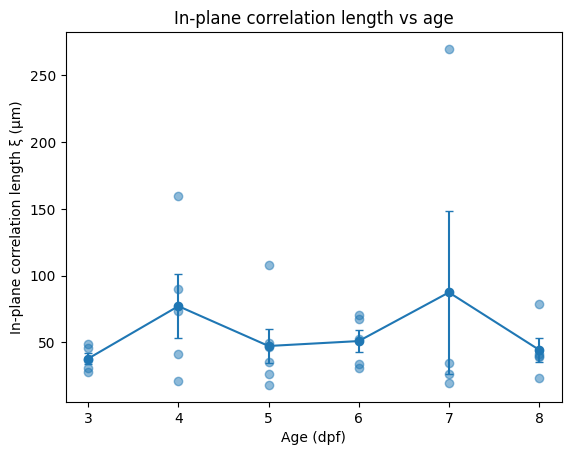

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# keep only finite age + finite in-plane xi
dfp = df_xi_inplane[
    np.isfinite(df_xi_inplane["age"]) &
    np.isfinite(df_xi_inplane["xi_um_inplane"])
].copy()

dfp["age"] = dfp["age"].astype(int)

# per-age summary
g = dfp.groupby("age")["xi_um_inplane"]
age = g.mean().index.to_numpy()
mu  = g.mean().to_numpy()
sem = (g.std(ddof=1) / np.sqrt(g.count())).to_numpy()

plt.figure()
plt.scatter(dfp["age"], dfp["xi_um_inplane"], alpha=0.5)
plt.errorbar(age, mu, yerr=sem, fmt="o-", capsize=3)
plt.xlabel("Age (dpf)")
plt.ylabel("In-plane correlation length ξ (µm)")
plt.title("In-plane correlation length vs age")
plt.show()


In [48]:
# -------------------------
# NEW: sample only OUT-OF-PLANE pairs
# -------------------------
def sample_pair_corr_dist_outofplane(
    Z, x_um, y_um, z_idx,
    n_pairs=1_000_000, seed=0,
    chunk_pairs=200_000, oversample_factor=3,
    dz_mode="any"   # "any" (|dz|>=1) or "adjacent" (|dz|==1)
):
    """
    Returns (d_xy, r) for pairs with z_idx[i] != z_idx[j] (or |dz|==1 if adjacent).
    Distance is XY only in microns (so you isolate lateral spread across planes).
    """
    rng = np.random.default_rng(seed)
    N, T = Z.shape

    d = np.empty(int(n_pairs), dtype=np.float32)
    r = np.empty(int(n_pairs), dtype=np.float32)

    filled = 0
    while filled < n_pairs:
        m = int(min((n_pairs - filled) * oversample_factor, 2_000_000))
        i = rng.integers(0, N, size=m, dtype=np.int32)
        j = rng.integers(0, N, size=m, dtype=np.int32)

        if dz_mode == "adjacent":
            ok = (i != j) & (np.abs(z_idx[i] - z_idx[j]) == 1)
        else:  # "any"
            ok = (i != j) & (z_idx[i] != z_idx[j])

        ii = i[ok]
        jj = j[ok]
        if ii.size == 0:
            continue

        take = min(ii.size, n_pairs - filled)
        ii = ii[:take]
        jj = jj[:take]

        # distances (XY only)
        dx = x_um[ii] - x_um[jj]
        dy = y_um[ii] - y_um[jj]
        d[filled:filled+take] = np.sqrt(dx*dx + dy*dy).astype(np.float32)

        # correlations (z-scored => corr = mean product)
        r[filled:filled+take] = (np.einsum("nt,nt->n", Z[ii], Z[jj], optimize=True) / (T - 1)).astype(np.float32)

        filled += take

    return d, r

# -------------------------
# high-level: compute xi OUT-OF-PLANE for one file
# -------------------------
def correlation_length_outofplane_from_files(
    dff_path, coord_path, *,
    xy_um=(0.8, 0.8),
    subsample_neurons=3000,
    n_pairs=1_000_000,
    nbins=60,
    dmax_percentile=99.5,
    seed=0,
    dz_mode="any"   # "any" or "adjacent"
):
    curr = np.load(coord_path, allow_pickle=True)
    xyz = curr[:, :3].astype(np.float32)

    z_idx = np.rint(xyz[:, 2]).astype(np.int32)
    x_um = xyz[:, 0] * float(xy_um[0])
    y_um = xyz[:, 1] * float(xy_um[1])

    dff = np.load(dff_path, allow_pickle=True).astype(np.float32)
    N, T = dff.shape
    rng = np.random.default_rng(seed)

    if subsample_neurons is not None and subsample_neurons < N:
        idx = rng.choice(N, size=int(subsample_neurons), replace=False)
        x_um, y_um, z_idx, dff = x_um[idx], y_um[idx], z_idx[idx], dff[idx]
        N = idx.size

    Z = zscore_rows(dff)

    d, r = sample_pair_corr_dist_outofplane(
        Z, x_um, y_um, z_idx,
        n_pairs=int(n_pairs),
        seed=int(seed),
        chunk_pairs=200_000,
        dz_mode=dz_mode
    )

    dmax = np.nanpercentile(d, float(dmax_percentile))
    dc, y, n, edges = bin_mean_abs_corr(d, r, nbins=int(nbins), dmax=float(dmax))
    xi_um, (a, c), ok = fit_xi_exponential(dc, y, n=n, fit_min_um=0.0, fit_max_um=float(dmax))
    return xi_um, dc, y, n, dmax, ok

# -------------------------
# batch OUT-OF-PLANE
# -------------------------
rows = []
for dff_path in tqdm(dff_l, desc="Corr length (out-of-plane)"):
    k = key_from_path(dff_path)
    if k not in coord_map:
        continue
    coord_path = coord_map[k]

    xi_um, dc, y, n, dmax, ok = correlation_length_outofplane_from_files(
        dff_path, coord_path,
        xy_um=(0.8, 0.8),
        subsample_neurons=3000,
        n_pairs=1_000_000,
        nbins=60,
        seed=0,
        dz_mode="any"       # <-- or "adjacent"
    )

    rows.append({
        "fish": k[0],
        "age": k[1],
        "dff_path": dff_path,
        "coord_path": coord_path,
        "xi_um_outofplane": xi_um,
        "dmax_um": dmax,
        "fit_ok": bool(ok),
        "dz_mode": "any",   # keep track
        "d_centers_um": dc,
        "mean_abs_corr": y,
        "n_pairs_bin": n,
    })

df_xi_out = pd.DataFrame(rows)
print(df_xi_out[["fish", "age", "xi_um_outofplane", "fit_ok", "dz_mode"]].head())


Corr length (out-of-plane): 100%|████████████████████| 30/30 [02:06<00:00,  4.22s/it]

                 fish  age  xi_um_outofplane  fit_ok dz_mode
0  BLNDEV-WILDTYPE-01  4.0        838.843895    True     any
1  BLNDEV-WILDTYPE-01  5.0         46.731659    True     any
2  BLNDEV-WILDTYPE-01  6.0        195.118370    True     any
3  BLNDEV-WILDTYPE-01  7.0         19.244309    True     any
4  BLNDEV-WILDTYPE-01  8.0         85.334206    True     any


In [43]:
import os, re, glob
import numpy as np
import pandas as pd
from tqdm import tqdm

try:
    from scipy.optimize import curve_fit
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# -------------------------
# filename parsers (reuse yours)
# -------------------------
def parse_fish_id(path: str) -> str:
    base = os.path.basename(path)
    m = re.search(r"(BLNDEV-WILDTYPE-\d+)", base)
    return m.group(1) if m else base.split("_")[0]

def parse_age_dpf(path: str) -> float:
    base = os.path.basename(path)
    m = re.search(r"(\d+)\s*dpf", base, flags=re.IGNORECASE) or re.search(r"(\d+)dpf", base, flags=re.IGNORECASE)
    return float(m.group(1)) if m else np.nan

# -------------------------
# core: sample correlations vs distance
# -------------------------
def zscore_rows(X, eps=1e-6):
    X = np.asarray(X, dtype=np.float32)
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True)
    return (X - mu) / (sd + eps)

def sample_pair_corr_dist(Z, xyz_um, n_pairs=1_000_000, seed=0, chunk_pairs=200_000):
    """
    Z: (N,T) z-scored traces (float32)
    xyz_um: (N,3) coords in microns (float32/64)
    Returns: d (M,), r (M,) where r is Pearson corr (since Z is z-scored)
    """
    rng = np.random.default_rng(seed)
    N, T = Z.shape
    xyz_um = np.asarray(xyz_um, dtype=np.float32)

    # sample random pairs (i<j not enforced; OK for estimates)
    i = rng.integers(0, N, size=n_pairs, dtype=np.int32)
    j = rng.integers(0, N, size=n_pairs, dtype=np.int32)
    # avoid self-pairs
    same = (i == j)
    if np.any(same):
        j[same] = (j[same] + 1) % N

    d = np.empty(n_pairs, dtype=np.float32)
    r = np.empty(n_pairs, dtype=np.float32)

    # chunked computation to keep memory sane
    for a in range(0, n_pairs, chunk_pairs):
        b = min(a + chunk_pairs, n_pairs)
        ii = i[a:b]
        jj = j[a:b]

        # distances
        diff = xyz_um[ii] - xyz_um[jj]
        d[a:b] = np.sqrt((diff * diff).sum(axis=1), dtype=np.float32)

        # correlations: for z-scored rows, corr = mean(Zi * Zj)
        # einsum is fast and avoids materializing (chunk,T) products
        r[a:b] = np.einsum("nt,nt->n", Z[ii], Z[jj], optimize=True) / (Z.shape[1] - 1)

    return d, r

def bin_mean_abs_corr(d, r, nbins=50, dmax=None):
    d = np.asarray(d, dtype=np.float32)
    r = np.asarray(r, dtype=np.float32)
    if dmax is None:
        dmax = np.nanpercentile(d, 99.5)
    edges = np.linspace(0.0, float(dmax), nbins + 1, dtype=np.float32)
    centers = 0.5 * (edges[:-1] + edges[1:])
    which = np.clip(np.searchsorted(edges, d, side="right") - 1, 0, nbins - 1)

    # mean |r| per bin (robust summary)
    y = np.zeros(nbins, dtype=np.float32)
    n = np.zeros(nbins, dtype=np.int64)
    absr = np.abs(r)

    np.add.at(y, which, absr)
    np.add.at(n, which, 1)
    y = np.where(n > 0, y / np.maximum(n, 1), np.nan)

    return centers, y, n, edges

def fit_xi_exponential(d_centers, y, n=None, fit_min_um=0.0, fit_max_um=None):
    """
    Fit y(d) ≈ a*exp(-d/xi) + c to binned mean |r|.
    Returns xi (microns), plus (a,c) and a success flag.
    """
    d_centers = np.asarray(d_centers, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)

    ok = np.isfinite(d_centers) & np.isfinite(y) & (y > 0)
    if fit_max_um is not None:
        ok &= (d_centers <= float(fit_max_um))
    ok &= (d_centers >= float(fit_min_um))

    dfit = d_centers[ok]
    yfit = y[ok]
    if dfit.size < 6:
        return np.nan, (np.nan, np.nan), False

    # weights ~ sqrt(n) if provided
    if n is not None:
        w = np.sqrt(np.asarray(n, dtype=np.float64)[ok])
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    else:
        w = None

    # model
    def model(d, a, xi, c):
        return a * np.exp(-d / xi) + c

    # initial guesses
    c0 = np.nanmin(yfit[-max(3, yfit.size//5):])  # baseline from far tail
    a0 = max(np.nanmax(yfit) - c0, 1e-6)
    xi0 = max(np.nanmedian(dfit), 1.0)

    # fit
    if _HAS_SCIPY:
        try:
            popt, _ = curve_fit(
                model, dfit, yfit,
                p0=(a0, xi0, c0),
                bounds=([0.0, 1e-3, 0.0], [np.inf, np.inf, np.inf]),
                sigma=(1.0 / w) if w is not None else None,
                absolute_sigma=False,
                maxfev=20_000
            )
            a, xi, c = popt
            return float(xi), (float(a), float(c)), True
        except Exception:
            pass

    # fallback: ignore offset, fit log-linear on (y - c0)
    y2 = yfit - c0
    ok2 = y2 > 0
    if ok2.sum() < 6:
        return np.nan, (np.nan, np.nan), False
    d2 = dfit[ok2]
    ly = np.log(y2[ok2])
    A = np.c_[np.ones_like(d2), -d2]
    coef, *_ = np.linalg.lstsq(A, ly, rcond=None)
    # ly ≈ b0 + b1*(-d) => slope = -1/xi
    slope = coef[1]
    xi = 1.0 / max(slope, 1e-12)
    return float(xi), (np.nan, float(c0)), True

# -------------------------
# high-level: compute xi for one file
# -------------------------
def correlation_length_from_files(dff_path, coord_path, *,
                                  xy_scale=(0.8, 0.8, 5),
                                  subsample_neurons=3000,
                                  n_pairs=1_000_000,
                                  nbins=60,
                                  dmax_percentile=99.5,
                                  seed=0):
    curr = np.load(coord_path, allow_pickle=True)
    xyz_um = curr[:, :3].astype(np.float32) * np.array(xy_scale, dtype=np.float32)

    dff = np.load(dff_path, allow_pickle=True).astype(np.float32)
    N, T = dff.shape

    rng = np.random.default_rng(seed)

    # optional subsample neurons for speed
    if subsample_neurons is not None and subsample_neurons < N:
        idx = rng.choice(N, size=int(subsample_neurons), replace=False)
        xyz_um = xyz_um[idx]
        dff = dff[idx]
        N = idx.size

    Z = zscore_rows(dff)

    d, r = sample_pair_corr_dist(Z, xyz_um, n_pairs=int(n_pairs), seed=int(seed), chunk_pairs=200_000)
    dmax = np.nanpercentile(d, float(dmax_percentile))
    dc, y, n, edges = bin_mean_abs_corr(d, r, nbins=int(nbins), dmax=float(dmax))

    xi_um, (a, c), ok = fit_xi_exponential(dc, y, n=n, fit_min_um=0.0, fit_max_um=float(dmax))
    return xi_um, dc, y, n, dmax, ok

# -------------------------
# batch over your folder
# -------------------------
fdata = "/home/dburrows/DATA/BLNDEV-WILDTYPE"
dff_l   = np.sort(glob.glob(f"{fdata}/*regdeltaff*"))
coord_l = np.sort(glob.glob(f"{fdata}/*labcoord*"))

# naive pairing: match by fish id + age from filenames
def key_from_path(p):
    return (parse_fish_id(p), parse_age_dpf(p))

coord_map = {key_from_path(p): p for p in coord_l}

rows = []
for dff_path in tqdm(dff_l, desc="Corr length"):
    k = key_from_path(dff_path)
    if k not in coord_map:
        continue
    coord_path = coord_map[k]

    xi_um, dc, y, n, dmax, ok = correlation_length_from_files(
        dff_path, coord_path,
        subsample_neurons=3000,   # bump to None for full N (slower)
        n_pairs=1_000_000,        # increase for smoother curves
        nbins=60,
        seed=0
    )

    rows.append({
        "fish": k[0],
        "age": k[1],
        "dff_path": dff_path,
        "coord_path": coord_path,
        "xi_um": xi_um,
        "dmax_um": dmax,
        "fit_ok": bool(ok),
        # keep the binned curve for later plotting (optional)
        "d_centers_um": dc,
        "mean_abs_corr": y,
        "n_pairs_bin": n,
    })

df_xi = pd.DataFrame(rows)
print(df_xi[["fish","age","xi_um","fit_ok"]].head())

Corr length: 100%|███████████████████████████████████| 30/30 [02:30<00:00,  5.00s/it]

                 fish  age        xi_um  fit_ok
0  BLNDEV-WILDTYPE-01  4.0   293.301588    True
1  BLNDEV-WILDTYPE-01  5.0   232.382209    True
2  BLNDEV-WILDTYPE-01  6.0  1035.414184    True
3  BLNDEV-WILDTYPE-01  7.0  2167.883850    True
4  BLNDEV-WILDTYPE-01  8.0   159.258022    True


In [ ]:
make me a simple network null showing that in uncorrelated networks of increasing size the correlation length would not increase

make it as fast as possible
just do a circ permute and complete random shuffle and dependent shuffle on my time series n times and then output


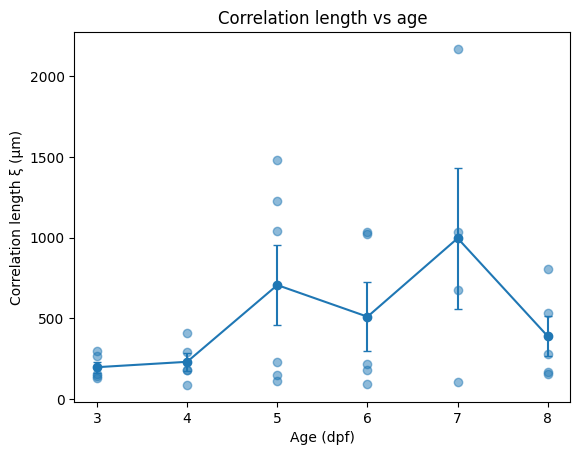

In [44]:
import numpy as np
import matplotlib.pyplot as plt

dfp = df_xi[np.isfinite(df_xi["age"]) & np.isfinite(df_xi["xi_um"])].copy()
dfp["age"] = dfp["age"].astype(int)

# per-age summary
g = dfp.groupby("age")["xi_um"]
age = g.mean().index.to_numpy()
mu  = g.mean().to_numpy()
sem = (g.std(ddof=1) / np.sqrt(g.count())).to_numpy()

plt.figure()
plt.scatter(dfp["age"], dfp["xi_um"], alpha=0.5)
plt.errorbar(age, mu, yerr=sem, fmt="o-", capsize=3)
plt.xlabel("Age (dpf)")
plt.ylabel("Correlation length ξ (µm)")
plt.title("Correlation length vs age")
plt.show()


In [35]:
import numpy as np
from scipy.stats import spearmanr

x = dfp["age"].to_numpy(dtype=float)
y = dfp["xi_um"].to_numpy(dtype=float)

mask = np.isfinite(x) & np.isfinite(y)
rho, p = spearmanr(x[mask], y[mask])

print(f"Spearman rho = {rho:.3f}, p = {p:.3g}")

Spearman rho = -0.513, p = 0.00372


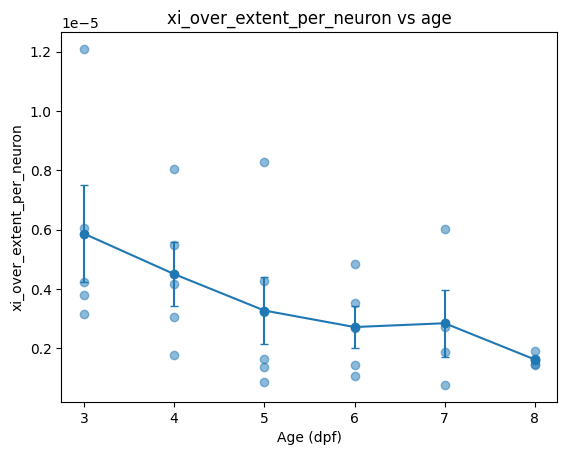

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# ---- helpers
def load_n_neurons(dff_path):
    # load shape only
    arr = np.load(dff_path, allow_pickle=True)
    return int(arr.shape[0])

def spatial_extent_L_um(coord_path, scale=(0.8, 0.8, 15.0)):
    curr = np.load(coord_path, allow_pickle=True)
    xyz = curr[:, :3].astype(float) * np.array(scale, float)

    # robust "diameter": 2 * 99th percentile radius from centroid
    ctr = xyz.mean(axis=0, keepdims=True)
    r = np.sqrt(((xyz - ctr) ** 2).sum(axis=1))
    L = 2.0 * np.percentile(r, 99)
    return float(L)

# ---- prepare plotting df
dfp = df_xi[np.isfinite(df_xi["age"]) & np.isfinite(df_xi["xi_um"])].copy()
dfp["age"] = dfp["age"].astype(int)

# add N if missing
if "n_neurons" not in dfp.columns:
    dfp["n_neurons"] = [load_n_neurons(p) for p in dfp["dff_path"].to_numpy()]

# add spatial extent if missing
if "L_um" not in dfp.columns:
    dfp["L_um"] = [spatial_extent_L_um(p) for p in dfp["coord_path"].to_numpy()]

# two normalisations
dfp["xi_per_neuron"] = dfp["xi_um"] / dfp["n_neurons"]
dfp["xi_over_extent"] = dfp["xi_um"] / dfp["L_um"]
dfp["xi_over_extent_per_neuron"] = dfp["xi_um"] / (dfp["L_um"] * dfp["n_neurons"])

# ---- choose what you want to plot (pick one)
ycol = "xi_over_extent_per_neuron"   # or "xi_per_neuron" or "xi_over_extent" or "xi_um"

# per-age summary
g = dfp.groupby("age")[ycol]
age = g.mean().index.to_numpy()
mu  = g.mean().to_numpy()
sem = (g.std(ddof=1) / np.sqrt(g.count())).to_numpy()

plt.figure()
plt.scatter(dfp["age"], dfp[ycol], alpha=0.5)
plt.errorbar(age, mu, yerr=sem, fmt="o-", capsize=3)
plt.xlabel("Age (dpf)")
plt.ylabel(ycol)
plt.title(f"{ycol} vs age")
plt.show()

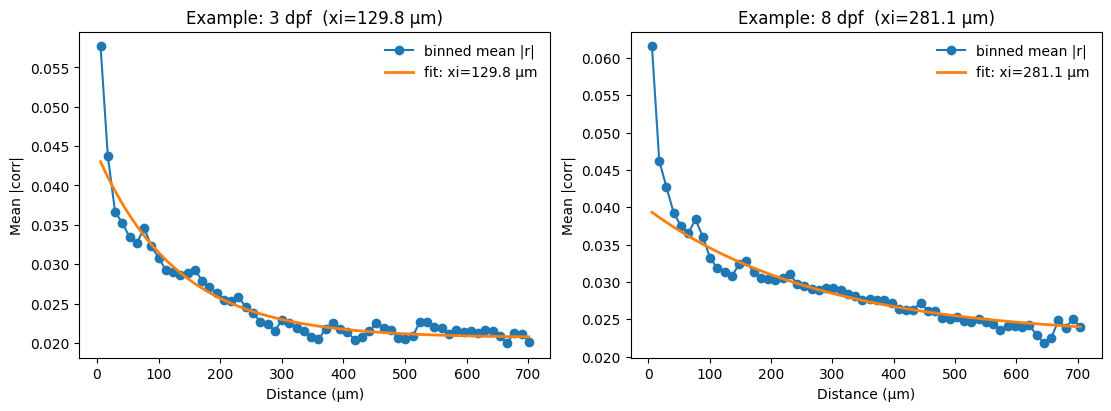

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# model used in fit
def model_exp(d, a, xi, c):
    return a * np.exp(-d / xi) + c

def fit_params_for_curve(d_centers, y, n=None, fit_min_um=0.0, fit_max_um=None):
    """
    Returns (xi, a, c, ok) using same method as fit_xi_exponential,
    but also returns a and c if scipy fit succeeds.
    """
    d_centers = np.asarray(d_centers, dtype=float)
    y = np.asarray(y, dtype=float)
    okmask = np.isfinite(d_centers) & np.isfinite(y) & (y > 0)

    if fit_max_um is not None:
        okmask &= (d_centers <= float(fit_max_um))
    okmask &= (d_centers >= float(fit_min_um))

    dfit = d_centers[okmask]
    yfit = y[okmask]
    if dfit.size < 6:
        return np.nan, np.nan, np.nan, False

    # weights ~ sqrt(n)
    if n is not None:
        w = np.sqrt(np.asarray(n, dtype=float)[okmask])
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    else:
        w = None

    c0 = np.nanmin(yfit[-max(3, yfit.size//5):])
    a0 = max(np.nanmax(yfit) - c0, 1e-6)
    xi0 = max(np.nanmedian(dfit), 1.0)

    if _HAS_SCIPY:
        from scipy.optimize import curve_fit
        try:
            popt, _ = curve_fit(
                model_exp, dfit, yfit,
                p0=(a0, xi0, c0),
                bounds=([0.0, 1e-3, 0.0], [np.inf, np.inf, np.inf]),
                sigma=(1.0 / w) if w is not None else None,
                absolute_sigma=False,
                maxfev=20_000
            )
            a, xi, c = popt
            return float(xi), float(a), float(c), True
        except Exception:
            pass

    # fallback: return xi from log-linear, keep c0 as baseline
    xi, (_, c), ok = fit_xi_exponential(d_centers, y, n=n, fit_min_um=fit_min_um, fit_max_um=fit_max_um)
    return float(xi), np.nan, float(c0), bool(ok)

def plot_example(row, ax, title_prefix=""):
    d = np.asarray(row["d_centers_um"])
    y = np.asarray(row["mean_abs_corr"])
    n = np.asarray(row["n_pairs_bin"]) if "n_pairs_bin" in row and row["n_pairs_bin"] is not None else None
    dmax = float(row["dmax_um"]) if np.isfinite(row["dmax_um"]) else np.nanmax(d)

    xi, a, c, ok = fit_params_for_curve(d, y, n=n, fit_max_um=dmax)

    ax.plot(d, y, marker="o", linestyle="-", label="binned mean |r|")

    if ok and np.isfinite(xi):
        xx = np.linspace(np.nanmin(d), np.nanmax(d), 300)
        if np.isfinite(a):
            yy = model_exp(xx, a, xi, c)
        else:
            # if a missing (fallback fit), estimate a from first point
            a_est = max(y[0] - c, 1e-6)
            yy = model_exp(xx, a_est, xi, c)
        ax.plot(xx, yy, linewidth=2, label=f"fit: xi={xi:.1f} µm")

    ax.set_xlabel("Distance (µm)")
    ax.set_ylabel("Mean |corr|")
    ax.set_title(f"{title_prefix}{int(row['age'])} dpf  (xi={xi:.1f} µm)")
    ax.legend(frameon=False)

# -------------------------
# pick one example per age
# -------------------------
df_ok = df_xi[df_xi["fit_ok"]].copy()
df_ok["age_int"] = df_ok["age"].astype(int)

row3 = df_ok[df_ok["age_int"] == 3].iloc[1]   # first 3 dpf that fits
row8 = df_ok[df_ok["age_int"] == 8].iloc[1]   # first 8 dpf that fits

# -------------------------
# plot side-by-side
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
plot_example(row3, axes[0], title_prefix="Example: ")
plot_example(row8, axes[1], title_prefix="Example: ")
plt.show()


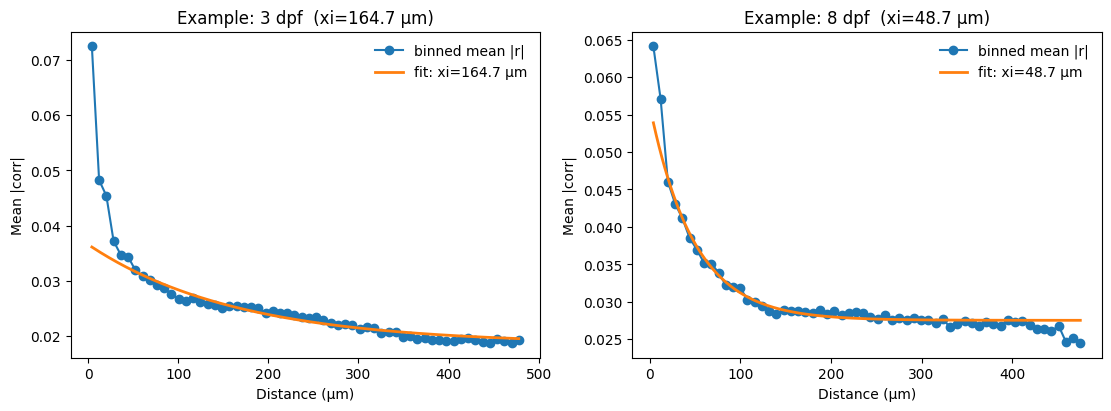

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# model used in fit
def model_exp(d, a, xi, c):
    return a * np.exp(-d / xi) + c

def fit_params_for_curve(d_centers, y, n=None, fit_min_um=0.0, fit_max_um=None):
    """
    Returns (xi, a, c, ok) using same method as fit_xi_exponential,
    but also returns a and c if scipy fit succeeds.
    """
    d_centers = np.asarray(d_centers, dtype=float)
    y = np.asarray(y, dtype=float)
    okmask = np.isfinite(d_centers) & np.isfinite(y) & (y > 0)

    if fit_max_um is not None:
        okmask &= (d_centers <= float(fit_max_um))
    okmask &= (d_centers >= float(fit_min_um))

    dfit = d_centers[okmask]
    yfit = y[okmask]
    if dfit.size < 6:
        return np.nan, np.nan, np.nan, False

    # weights ~ sqrt(n)
    if n is not None:
        w = np.sqrt(np.asarray(n, dtype=float)[okmask])
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    else:
        w = None

    c0 = np.nanmin(yfit[-max(3, yfit.size//5):])
    a0 = max(np.nanmax(yfit) - c0, 1e-6)
    xi0 = max(np.nanmedian(dfit), 1.0)

    if _HAS_SCIPY:
        from scipy.optimize import curve_fit
        try:
            popt, _ = curve_fit(
                model_exp, dfit, yfit,
                p0=(a0, xi0, c0),
                bounds=([0.0, 1e-3, 0.0], [np.inf, np.inf, np.inf]),
                sigma=(1.0 / w) if w is not None else None,
                absolute_sigma=False,
                maxfev=20_000
            )
            a, xi, c = popt
            return float(xi), float(a), float(c), True
        except Exception:
            pass

    # fallback: return xi from log-linear, keep c0 as baseline
    xi, (_, c), ok = fit_xi_exponential(d_centers, y, n=n, fit_min_um=fit_min_um, fit_max_um=fit_max_um)
    return float(xi), np.nan, float(c0), bool(ok)

def plot_example(row, ax, title_prefix=""):
    d = np.asarray(row["d_centers_um"])
    y = np.asarray(row["mean_abs_corr"])
    n = np.asarray(row["n_pairs_bin"]) if "n_pairs_bin" in row and row["n_pairs_bin"] is not None else None
    dmax = float(row["dmax_um"]) if np.isfinite(row["dmax_um"]) else np.nanmax(d)

    xi, a, c, ok = fit_params_for_curve(d, y, n=n, fit_max_um=dmax)

    ax.plot(d, y, marker="o", linestyle="-", label="binned mean |r|")

    if ok and np.isfinite(xi):
        xx = np.linspace(np.nanmin(d), np.nanmax(d), 300)
        if np.isfinite(a):
            yy = model_exp(xx, a, xi, c)
        else:
            # if a missing (fallback fit), estimate a from first point
            a_est = max(y[0] - c, 1e-6)
            yy = model_exp(xx, a_est, xi, c)
        ax.plot(xx, yy, linewidth=2, label=f"fit: xi={xi:.1f} µm")

    ax.set_xlabel("Distance (µm)")
    ax.set_ylabel("Mean |corr|")
    ax.set_title(f"{title_prefix}{int(row['age'])} dpf  (xi={xi:.1f} µm)")
    ax.legend(frameon=False)

# -------------------------
# pick one example per age
# -------------------------
df_ok = df_xi[df_xi["fit_ok"]].copy()
df_ok["age_int"] = df_ok["age"].astype(int)

row3 = df_ok[df_ok["age_int"] == 3].iloc[1]   # first 3 dpf that fits
row8 = df_ok[df_ok["age_int"] == 8].iloc[1]   # first 8 dpf that fits

# -------------------------
# plot side-by-side
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
plot_example(row3, axes[0], title_prefix="Example: ")
plot_example(row8, axes[1], title_prefix="Example: ")
plt.show()


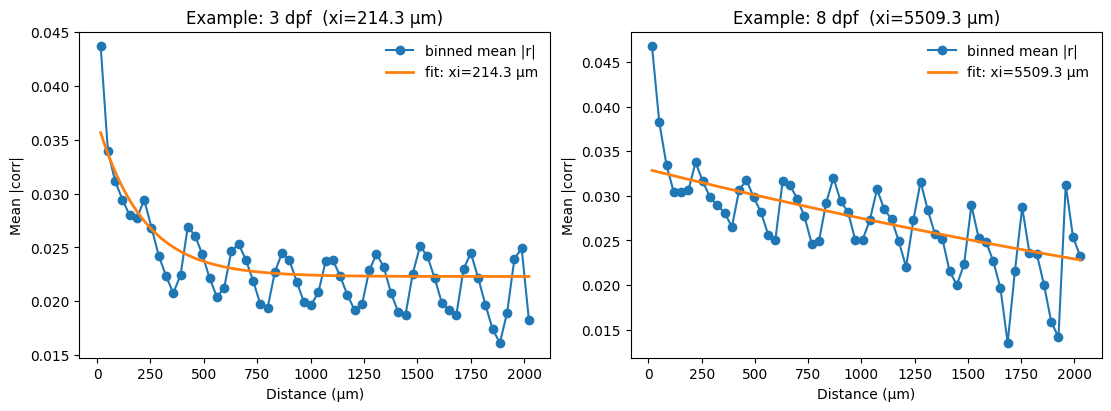

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# model used in fit
def model_exp(d, a, xi, c):
    return a * np.exp(-d / xi) + c

def fit_params_for_curve(d_centers, y, n=None, fit_min_um=0.0, fit_max_um=None):
    """
    Returns (xi, a, c, ok) using same method as fit_xi_exponential,
    but also returns a and c if scipy fit succeeds.
    """
    d_centers = np.asarray(d_centers, dtype=float)
    y = np.asarray(y, dtype=float)
    okmask = np.isfinite(d_centers) & np.isfinite(y) & (y > 0)

    if fit_max_um is not None:
        okmask &= (d_centers <= float(fit_max_um))
    okmask &= (d_centers >= float(fit_min_um))

    dfit = d_centers[okmask]
    yfit = y[okmask]
    if dfit.size < 6:
        return np.nan, np.nan, np.nan, False

    # weights ~ sqrt(n)
    if n is not None:
        w = np.sqrt(np.asarray(n, dtype=float)[okmask])
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    else:
        w = None

    c0 = np.nanmin(yfit[-max(3, yfit.size//5):])
    a0 = max(np.nanmax(yfit) - c0, 1e-6)
    xi0 = max(np.nanmedian(dfit), 1.0)

    if _HAS_SCIPY:
        from scipy.optimize import curve_fit
        try:
            popt, _ = curve_fit(
                model_exp, dfit, yfit,
                p0=(a0, xi0, c0),
                bounds=([0.0, 1e-3, 0.0], [np.inf, np.inf, np.inf]),
                sigma=(1.0 / w) if w is not None else None,
                absolute_sigma=False,
                maxfev=20_000
            )
            a, xi, c = popt
            return float(xi), float(a), float(c), True
        except Exception:
            pass

    # fallback: return xi from log-linear, keep c0 as baseline
    xi, (_, c), ok = fit_xi_exponential(d_centers, y, n=n, fit_min_um=fit_min_um, fit_max_um=fit_max_um)
    return float(xi), np.nan, float(c0), bool(ok)

def plot_example(row, ax, title_prefix=""):
    d = np.asarray(row["d_centers_um"])
    y = np.asarray(row["mean_abs_corr"])
    n = np.asarray(row["n_pairs_bin"]) if "n_pairs_bin" in row and row["n_pairs_bin"] is not None else None
    dmax = float(row["dmax_um"]) if np.isfinite(row["dmax_um"]) else np.nanmax(d)

    xi, a, c, ok = fit_params_for_curve(d, y, n=n, fit_max_um=dmax)

    ax.plot(d, y, marker="o", linestyle="-", label="binned mean |r|")

    if ok and np.isfinite(xi):
        xx = np.linspace(np.nanmin(d), np.nanmax(d), 300)
        if np.isfinite(a):
            yy = model_exp(xx, a, xi, c)
        else:
            # if a missing (fallback fit), estimate a from first point
            a_est = max(y[0] - c, 1e-6)
            yy = model_exp(xx, a_est, xi, c)
        ax.plot(xx, yy, linewidth=2, label=f"fit: xi={xi:.1f} µm")

    ax.set_xlabel("Distance (µm)")
    ax.set_ylabel("Mean |corr|")
    ax.set_title(f"{title_prefix}{int(row['age'])} dpf  (xi={xi:.1f} µm)")
    ax.legend(frameon=False)

# -------------------------
# pick one example per age
# -------------------------
df_ok = df_xi[df_xi["fit_ok"]].copy()
df_ok["age_int"] = df_ok["age"].astype(int)

row3 = df_ok[df_ok["age_int"] == 3].iloc[1]   # first 3 dpf that fits
row8 = df_ok[df_ok["age_int"] == 8].iloc[1]   # first 8 dpf that fits

# -------------------------
# plot side-by-side
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
plot_example(row3, axes[0], title_prefix="Example: ")
plot_example(row8, axes[1], title_prefix="Example: ")
plt.show()

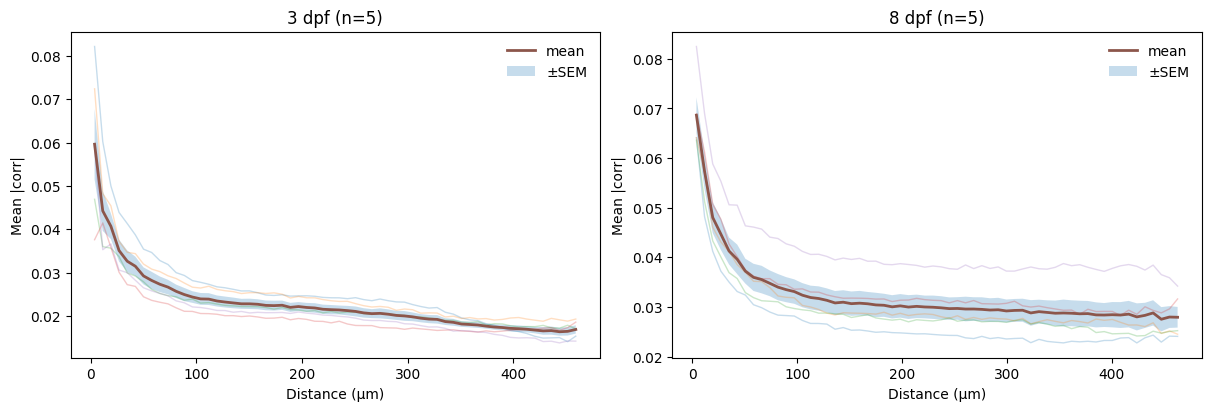

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def stack_curves(df_age):
    """Return (D, Y) where D=(nbins,), Y=(n_fish, nbins). Assumes common binning."""
    D = np.asarray(df_age.iloc[0]["d_centers_um"], dtype=float)
    Y = np.vstack([np.asarray(r["mean_abs_corr"], dtype=float) for _, r in df_age.iterrows()])
    return D, Y

df_ok = df_xi[df_xi["fit_ok"]].copy()
df_ok["age_int"] = df_ok["age"].astype(int)

df3 = df_ok[df_ok["age_int"] == 3].copy()
df8 = df_ok[df_ok["age_int"] == 8].copy()

# safety: require non-empty
assert len(df3) > 0, "No fit_ok rows at 3 dpf"
assert len(df8) > 0, "No fit_ok rows at 8 dpf"

D3, Y3 = stack_curves(df3)
D8, Y8 = stack_curves(df8)

# mean ± SEM
mu3 = np.nanmean(Y3, axis=0)
se3 = np.nanstd(Y3, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(Y3), axis=0))
mu8 = np.nanmean(Y8, axis=0)
se8 = np.nanstd(Y8, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(Y8), axis=0))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# ---- 3 dpf panel
ax = axes[0]
for k in range(Y3.shape[0]):
    ax.plot(D3, Y3[k], alpha=0.25, linewidth=1)
ax.plot(D3, mu3, linewidth=2, label="mean")
ax.fill_between(D3, mu3 - se3, mu3 + se3, alpha=0.25, label="±SEM")
ax.set_title(f"3 dpf (n={Y3.shape[0]})")
ax.set_xlabel("Distance (µm)")
ax.set_ylabel("Mean |corr|")
ax.legend(frameon=False)

# ---- 8 dpf panel
ax = axes[1]
for k in range(Y8.shape[0]):
    ax.plot(D8, Y8[k], alpha=0.25, linewidth=1)
ax.plot(D8, mu8, linewidth=2, label="mean")
ax.fill_between(D8, mu8 - se8, mu8 + se8, alpha=0.25, label="±SEM")
ax.set_title(f"8 dpf (n={Y8.shape[0]})")
ax.set_xlabel("Distance (µm)")
ax.set_ylabel("Mean |corr|")
ax.legend(frameon=False)
plt.show()

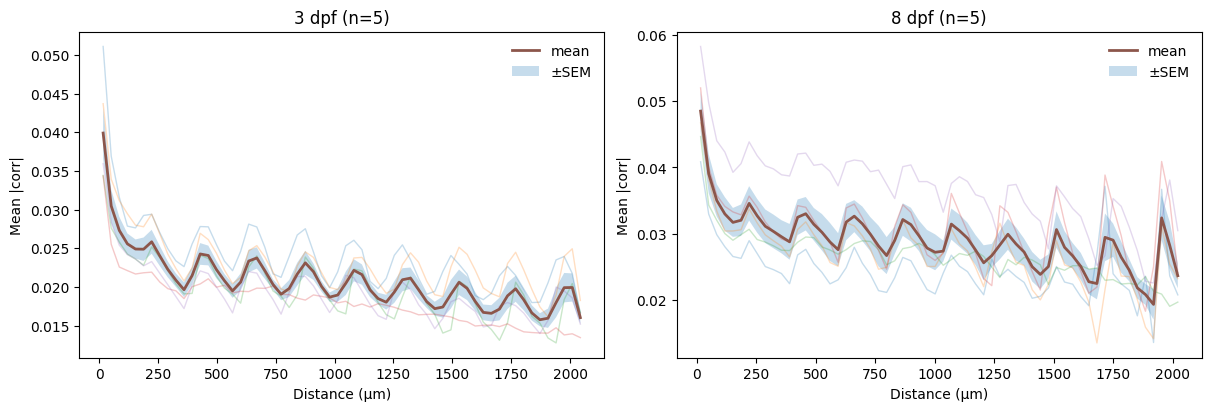

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def stack_curves(df_age):
    """Return (D, Y) where D=(nbins,), Y=(n_fish, nbins). Assumes common binning."""
    D = np.asarray(df_age.iloc[0]["d_centers_um"], dtype=float)
    Y = np.vstack([np.asarray(r["mean_abs_corr"], dtype=float) for _, r in df_age.iterrows()])
    return D, Y

df_ok = df_xi[df_xi["fit_ok"]].copy()
df_ok["age_int"] = df_ok["age"].astype(int)

df3 = df_ok[df_ok["age_int"] == 3].copy()
df8 = df_ok[df_ok["age_int"] == 8].copy()

# safety: require non-empty
assert len(df3) > 0, "No fit_ok rows at 3 dpf"
assert len(df8) > 0, "No fit_ok rows at 8 dpf"

D3, Y3 = stack_curves(df3)
D8, Y8 = stack_curves(df8)

# mean ± SEM
mu3 = np.nanmean(Y3, axis=0)
se3 = np.nanstd(Y3, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(Y3), axis=0))
mu8 = np.nanmean(Y8, axis=0)
se8 = np.nanstd(Y8, axis=0, ddof=1) / np.sqrt(np.sum(np.isfinite(Y8), axis=0))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# ---- 3 dpf panel
ax = axes[0]
for k in range(Y3.shape[0]):
    ax.plot(D3, Y3[k], alpha=0.25, linewidth=1)
ax.plot(D3, mu3, linewidth=2, label="mean")
ax.fill_between(D3, mu3 - se3, mu3 + se3, alpha=0.25, label="±SEM")
ax.set_title(f"3 dpf (n={Y3.shape[0]})")
ax.set_xlabel("Distance (µm)")
ax.set_ylabel("Mean |corr|")
ax.legend(frameon=False)

# ---- 8 dpf panel
ax = axes[1]
for k in range(Y8.shape[0]):
    ax.plot(D8, Y8[k], alpha=0.25, linewidth=1)
ax.plot(D8, mu8, linewidth=2, label="mean")
ax.fill_between(D8, mu8 - se8, mu8 + se8, alpha=0.25, label="±SEM")
ax.set_title(f"8 dpf (n={Y8.shape[0]})")
ax.set_xlabel("Distance (µm)")
ax.set_ylabel("Mean |corr|")
ax.legend(frameon=False)
plt.show()

In [17]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

# pick your normalised column
ycol = "xi_over_extent"   # <- change to the normalised metric you want

# vectors AFTER normalisation
x = dfp["age"].to_numpy(dtype=float)
y = dfp[ycol].to_numpy(dtype=float)

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# -----------------------
# Spearman + Pearson tests
# -----------------------
rho, p_rho = spearmanr(x, y)
r, p_r = pearsonr(x, y)
print(f"[{ycol}] Spearman rho={rho:.3f}, p={p_rho:.3g}")
print(f"[{ycol}] Pearson  r={r:.3f}, p={p_r:.3g}")

# -----------------------
# Permutation test on slope (robust)
# -----------------------
def slope(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    xm = x.mean()
    ym = y.mean()
    denom = np.sum((x - xm)**2)
    return np.sum((x - xm) * (y - ym)) / denom if denom > 0 else np.nan

rng = np.random.default_rng(0)
b_obs = slope(x, y)

n_perm = 10_000
b_perm = np.empty(n_perm, dtype=float)
for k in range(n_perm):
    b_perm[k] = slope(x, rng.permutation(y))

p_perm = (np.sum(np.abs(b_perm) >= np.abs(b_obs)) + 1) / (n_perm + 1)
print(f"[{ycol}] Permutation slope b={b_obs:.4g}, p={p_perm:.4g}")

[xi_over_extent] Spearman rho=0.331, p=0.074
[xi_over_extent] Pearson  r=0.359, p=0.0515
[xi_over_extent] Permutation slope b=0.2472, p=0.05669


In [18]:
import numpy as np
from scipy.stats import spearmanr, pearsonr

# pick your normalised column
ycol = "xi_per_neuron"   # <- change to the normalised metric you want

# vectors AFTER normalisation
x = dfp["age"].to_numpy(dtype=float)
y = dfp[ycol].to_numpy(dtype=float)

mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# -----------------------
# Spearman + Pearson tests
# -----------------------
rho, p_rho = spearmanr(x, y)
r, p_r = pearsonr(x, y)
print(f"[{ycol}] Spearman rho={rho:.3f}, p={p_rho:.3g}")
print(f"[{ycol}] Pearson  r={r:.3f}, p={p_r:.3g}")

# -----------------------
# Permutation test on slope (robust)
# -----------------------
def slope(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    xm = x.mean()
    ym = y.mean()
    denom = np.sum((x - xm)**2)
    return np.sum((x - xm) * (y - ym)) / denom if denom > 0 else np.nan

rng = np.random.default_rng(0)
b_obs = slope(x, y)

n_perm = 10_000
b_perm = np.empty(n_perm, dtype=float)
for k in range(n_perm):
    b_perm[k] = slope(x, rng.permutation(y))

p_perm = (np.sum(np.abs(b_perm) >= np.abs(b_obs)) + 1) / (n_perm + 1)
print(f"[{ycol}] Permutation slope b={b_obs:.4g}, p={p_perm:.4g}")

[xi_per_neuron] Spearman rho=0.380, p=0.0382
[xi_per_neuron] Pearson  r=0.351, p=0.0575
[xi_per_neuron] Permutation slope b=0.03667, p=0.06219


In [ ]:
#visualise clusters

